In [65]:
# Importing the libraries

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from io import BytesIO
import pycountry
import plotly.express as px
from scipy.stats import normaltest
from scipy.stats import f_oneway
import statsmodels.api as sm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import praw
from textblob import TextBlob
from statsmodels.formula.api import ols
from scipy.stats import kruskal
from scipy.stats import wilcoxon
from dotenv import load_dotenv
from os import getenv
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime
import plotly.graph_objects as go
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
from jupyter_dash import JupyterDash
from geopy.geocoders import Nominatim
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.stattools import adfuller
from numpy import log
import itertools
from itertools import product
import warnings
from scipy.stats import ttest_ind
import scipy.stats as ss
import statsmodels.api as sa
import scikit_posthocs as sp

Create the Dataset

In [66]:
url = 'https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/EI_ISBU_Q?format=TSV&compressed=true' # The url of the data

# Accept-Encoding: gzip is used to compress the data
headers = {'Accept-Encoding': 'gzip'} 

# Get the data from the url
response = requests.get(url, headers=headers) 
 
# Read the gzip file
buf = BytesIO(response.content)

# Unzip the gzip file
f = gzip.GzipFile(fileobj=buf) 

# Read the unzipped file
content = f.read() 

# Save the unzipped file (can be used to repeat the process without downloading the file again)
with open('Europe_Construction.tsv', 'wb') as f:
    f.write(content)

# Read the unzipped file as a dataframe
df = pd.read_csv(BytesIO(content), sep='\t') 

In [67]:
# Read the tsv file as a dataframe
#df = pd.read_csv('Europe_Construction.tsv', sep='\t')

# Print the first 5 rows of the dataframe
print(df.head())

  freq,unit,s_adj,indic,nace_r2,geo\TIME_PERIOD 1980-Q1  1980-Q2  1980-Q3   \
0                       Q,I2015,NSA,IS-EPI,F,AL       :        :        :    
1                       Q,I2015,NSA,IS-EPI,F,AT       :        :        :    
2                       Q,I2015,NSA,IS-EPI,F,BE       :        :        :    
3                       Q,I2015,NSA,IS-EPI,F,BG       :        :        :    
4                       Q,I2015,NSA,IS-EPI,F,CH       :        :        :    

  1980-Q4  1981-Q1  1981-Q2  1981-Q3  1981-Q4  1982-Q1   ... 2020-Q4   \
0       :        :        :        :        :        :   ...   119.4    
1       :        :        :        :        :        :   ...   116.9    
2       :        :        :        :        :        :   ...   108.2    
3       :        :        :        :        :        :   ...   103.3    
4       :        :        :        :        :        :   ...  102.1 e   

  2021-Q1  2021-Q2  2021-Q3  2021-Q4  2022-Q1  2022-Q2  2022-Q3  2022-Q4   \
0   123.7    12

In [68]:
# Melt the dataframe so all the Quarters are in one column
df = pd.melt(df, id_vars=['freq,unit,s_adj,indic,nace_r2,geo\TIME_PERIOD'], var_name='Quarter', value_name='Value')

# The column freq,unit,s_adj,indic,nace_r2,geo\TIME_PERIOD is split into 6 columns
df[['freq','unit','s_adj','indic','nace_r2','geo\TIME_PERIOD']] = df['freq,unit,s_adj,indic,nace_r2,geo\\TIME_PERIOD'].str.split(',', expand=True)

# svr the column freq,unit,s_adj,indic,nace_r2,geo\TIME_PERIOD and move Quarter and Value to the back
df = df.drop(['freq,unit,s_adj,indic,nace_r2,geo\\TIME_PERIOD'], axis=1)
df = df[['freq', 'unit', 's_adj', 'indic', 'nace_r2','geo\TIME_PERIOD','Quarter', 'Value']]

# Print the first 5 rows of the dataframe
df.head()

,freq,unit,s_adj,indic,nace_r2,geo\TIME_PERIOD,Quarter,Value
0,Q,I2015,NSA,IS-EPI,F,AL,1980-Q1,:
1,Q,I2015,NSA,IS-EPI,F,AT,1980-Q1,:
2,Q,I2015,NSA,IS-EPI,F,BE,1980-Q1,:
3,Q,I2015,NSA,IS-EPI,F,BG,1980-Q1,:
4,Q,I2015,NSA,IS-EPI,F,CH,1980-Q1,:


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70930 entries, 0 to 70929
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   freq             70930 non-null  object
 1   unit             70930 non-null  object
 2   s_adj            70930 non-null  object
 3   indic            70930 non-null  object
 4   nace_r2          70930 non-null  object
 5   geo\TIME_PERIOD  70930 non-null  object
 6   Quarter          70930 non-null  object
 7   Value            70930 non-null  object
dtypes: object(8)
memory usage: 4.3+ MB


In [70]:
# set values containing ":" to NaN
df.loc[df['Value'].str.contains(':'), 'Value'] = pd.np.nan

C:\Users\Paul\AppData\Local\Temp\ipykernel_58648\2627470230.py:2: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.



In [71]:
# if the Value column has an alphabetical character remove it
df['Value'] = df['Value'].str.replace('[a-zA-Z]', '')

C:\Users\Paul\AppData\Local\Temp\ipykernel_58648\2254030720.py:2: FutureWarning:

The default value of regex will change from True to False in a future version.



In [72]:
#Convert the Value column to a float
df['Value'] = df['Value'].astype(float)

In [73]:
df.head()

,freq,unit,s_adj,indic,nace_r2,geo\TIME_PERIOD,Quarter,Value
0,Q,I2015,NSA,IS-EPI,F,AL,1980-Q1,NaN
1,Q,I2015,NSA,IS-EPI,F,AT,1980-Q1,NaN
2,Q,I2015,NSA,IS-EPI,F,BE,1980-Q1,NaN
3,Q,I2015,NSA,IS-EPI,F,BG,1980-Q1,NaN
4,Q,I2015,NSA,IS-EPI,F,CH,1980-Q1,NaN


In [74]:
countrycode_map = {c.alpha_2: c.alpha_3 for c in pycountry.countries} # Create a dictionary of country codes

#Uk is not a country code so we will change it to GB
df.loc[df['geo\\TIME_PERIOD'] == 'UK', 'geo\\TIME_PERIOD'] = 'GB'

df['Country_Codes'] = df['geo\\TIME_PERIOD'].map(countrycode_map) # Map the country codes to the dataframe


In [75]:
# Print unique values of the Country_Codes column
print(df['Country_Codes'].unique())

['ALB' 'AUT' 'BEL' 'BGR' 'CHE' 'CYP' 'CZE' 'DEU' 'DNK' nan 'EST' 'ESP'
 'FIN' 'FRA' 'HRV' 'HUN' 'IRL' 'ISL' 'ITA' 'LTU' 'LUX' 'LVA' 'MNE' 'MKD'
 'MLT' 'NLD' 'NOR' 'POL' 'PRT' 'ROU' 'SRB' 'SWE' 'SVN' 'SVK' 'TUR' 'GBR'
 'BIH']


In [76]:
# Perform Normality tests for the Value column grouped by geo\TIME_PERIOD, indic, and s_adj

df.set_index(['geo\\TIME_PERIOD', 'indic', 's_adj'], inplace=True)

In [77]:
# Perform normality test on the Value column grouped by geo\TIME_PERIOD, indic, and s_adj
grouped = df.groupby(['geo\\TIME_PERIOD', 'indic', 's_adj'])['Value']
pvalues = grouped.apply(lambda x: normaltest(x.dropna())[1] if len(x.dropna()) >= 8 else float('NaN'))

In [78]:
# Add p-values to a new column in the original DataFrame
df.loc[pvalues.index, 'pvalue'] = pvalues

#Add a new column to the dfi dataframe called 'normal' and set it to True if the pvalue is greater than 0.05 and False if it is less than 0.05
df['normal'] = df['pvalue'] > 0.05

# Move the index back to columns
df.reset_index(inplace=True)

Explore the Data

In [79]:
df.head()

,geo\TIME_PERIOD,indic,s_adj,freq,unit,nace_r2,Quarter,Value,Country_Codes,pvalue,normal
0,AL,IS-EPI,NSA,Q,I2015,F,1980-Q1,NaN,ALB,3.147198e-07,False
1,AT,IS-EPI,NSA,Q,I2015,F,1980-Q1,NaN,AUT,9.124828e-01,True
2,BE,IS-EPI,NSA,Q,I2015,F,1980-Q1,NaN,BEL,5.347295e-02,True
3,BG,IS-EPI,NSA,Q,I2015,F,1980-Q1,NaN,BGR,5.078610e-06,False
4,CH,IS-EPI,NSA,Q,I2015,F,1980-Q1,NaN,CHE,4.057631e-14,False


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70930 entries, 0 to 70929
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   geo\TIME_PERIOD  70930 non-null  object 
 1   indic            70930 non-null  object 
 2   s_adj            70930 non-null  object 
 3   freq             70930 non-null  object 
 4   unit             70930 non-null  object 
 5   nace_r2          70930 non-null  object 
 6   Quarter          70930 non-null  object 
 7   Value            38091 non-null  float64
 8   Country_Codes    62799 non-null  object 
 9   pvalue           70930 non-null  float64
 10  normal           70930 non-null  bool   
dtypes: bool(1), float64(2), object(8)
memory usage: 5.5+ MB


In [81]:
df.describe(include='all')

,geo\TIME_PERIOD,indic,s_adj,freq,unit,nace_r2,Quarter,Value,Country_Codes,pvalue,normal
count,70930,70930,70930,70930,70930,70930,70930,38091.000000,62799,70930.000000,70930
unique,41,6,2,1,1,2,173,NaN,36,NaN,2
top,SE,IS-EPI,NSA,Q,I2015,F,1980-Q1,NaN,LTU,NaN,False
freq,1903,13840,37368,70930,70930,53111,410,NaN,1903,NaN,48267
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125.682796,NaN,0.116983,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.849931,NaN,0.218288,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.200000,NaN,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.300000,NaN,0.000039,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.900000,NaN,0.007303,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122.400000,NaN,0.113613,NaN


In [82]:
# Group the dataframe by geo\TIME_PERIOD, indic, and s_adj and show descriptive statistics
df.groupby(['s_adj', 'indic', 'geo\\TIME_PERIOD']).describe()

Value                                        \
                              count        mean         std   min     25%   
s_adj indic  geo\TIME_PERIOD                                                
NSA   IS-EPI AL                72.0   94.238889   20.209345  60.5  78.725   
             AT               109.0  102.975229   10.071661  80.6  98.800   
             BE                92.0   98.146739    9.608129  79.5  89.400   
             BG                92.0  105.111957   26.287434  66.6  92.600   
             CH               101.0   94.242574    7.442182  81.3  87.200   
...                             ...         ...         ...   ...     ...   
SCA   IS-WSI RS                92.0   78.221739   39.282705   5.5  46.525   
             SE                92.0   84.520652   31.513568  39.6  52.950   
             SI                92.0   95.882609   19.253420  54.7  81.375   
             SK                93.0   96.474194   27.270779  50.6  75.000   
             TR                73.0  121.957534  116.949379  27.5  52.300   

                                                     pvalue                \
                                 50%      75%    max  count          mean   
s_adj indic  geo\TIME_PERIOD                                                
NSA   IS-EPI AL                90.15  113.425  129.5  173.0  3.147198e-07   
             AT               103.60  108.300  126.5  173.0  9.124828e-01   
             BE               100.15  103.475  116.3  173.0  5.347295e-02   
             BG               100.45  112.750  188.3  173.0  5.078610e-06   
             CH                95.20  100.900  106.8  173.0  4.057631e-14   
...                              ...      ...    ...    ...           ...   
SCA   IS-WSI RS                86.55   98.575  164.5  173.0  3.022109e-01   
             SE                78.20  111.700  151.1  173.0  4.819845e-05   
             SI               100.25  105.425  139.0  173.0  5.516290e-01   
             SK               101.30  110.300  140.8  173.0  3.194666e-03   
             TR                81.80  157.900  690.3  173.0  9.525851e-15   

                                                                        \
                                       std           min           25%   
s_adj indic  geo\TIME_PERIOD                                             
NSA   IS-EPI AL               4.778391e-22  3.147198e-07  3.147198e-07   
             AT               3.006303e-15  9.124828e-01  9.124828e-01   
             BE               2.087711e-17  5.347295e-02  5.347295e-02   
             BG               8.494917e-21  5.078610e-06  5.078610e-06   
             CH               1.392425e-28  4.057631e-14  4.057631e-14   
...                                    ...           ...           ...   
SCA   IS-WSI RS               6.123952e-16  3.022109e-01  3.022109e-01   
             SE               1.155309e-19  4.819845e-05  4.819845e-05   
             SI               2.226891e-15  5.516290e-01  5.516290e-01   
             SK               9.568674e-18  3.194666e-03  3.194666e-03   
             TR               2.531683e-29  9.525851e-15  9.525851e-15   

                                                                        
                                       50%           75%           max  
s_adj indic  geo\TIME_PERIOD                                            
NSA   IS-EPI AL               3.147198e-07  3.147198e-07  3.147198e-07  
             AT               9.124828e-01  9.124828e-01  9.124828e-01  
             BE               5.347295e-02  5.347295e-02  5.347295e-02  
             BG               5.078610e-06  5.078610e-06  5.078610e-06  
             CH               4.057631e-14  4.057631e-14  4.057631e-14  
...                                    ...           ...           ...  
SCA   IS-WSI RS               3.022109e-01  3.022109e-01  3.022109e-01  
             SE               4.819845e-05  4.819845e-05  4.819845e-05  
             SI               5.

In [83]:
# Seperate the geo\TIME_PERIOD value that equals 'IE' into a seperate dataframe
IE = df[df['geo\TIME_PERIOD'] == 'IE']

In [84]:
# Create a unit test to check if seperating the dataframe worked
assert IE['geo\TIME_PERIOD'].unique() == 'IE'

In [85]:
#Perform EDA on the IE dataframe
IE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1730 entries, 20 to 70911
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   geo\TIME_PERIOD  1730 non-null   object 
 1   indic            1730 non-null   object 
 2   s_adj            1730 non-null   object 
 3   freq             1730 non-null   object 
 4   unit             1730 non-null   object 
 5   nace_r2          1730 non-null   object 
 6   Quarter          1730 non-null   object 
 7   Value            924 non-null    float64
 8   Country_Codes    1730 non-null   object 
 9   pvalue           1730 non-null   float64
 10  normal           1730 non-null   bool   
dtypes: bool(1), float64(2), object(8)
memory usage: 150.4+ KB


In [86]:
IE.describe(include='all')

,geo\TIME_PERIOD,indic,s_adj,freq,unit,nace_r2,Quarter,Value,Country_Codes,pvalue,normal
count,1730,1730,1730,1730,1730,1730,1730,924.000000,1730,1.730000e+03,1730
unique,1,5,2,1,1,2,173,NaN,1,NaN,2
top,IE,IS-EPI,NSA,Q,I2015,F,1980-Q1,NaN,IRL,NaN,False
freq,1730,346,865,1730,1730,1384,10,NaN,1730,NaN,1384
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187.061905,NaN,2.027689e-02,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152.921170,NaN,2.426774e-02,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.600000,NaN,1.356442e-15,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.025000,NaN,7.872037e-04,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138.650000,NaN,2.650638e-03,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,197.425000,NaN,4.167024e-02,NaN


In [87]:
# Perform Statistical Analysis on the IE dataframe
IE.describe(include='all')

IE.groupby(['indic','s_adj']).describe()

Value                                                          \
             count        mean         std   min      25%     50%      75%   
indic  s_adj                                                                 
IS-EPI NSA    92.0  131.552174   36.385586  69.0  102.400  130.85  151.700   
       SCA    92.0  131.546739   36.343052  69.9  101.725  131.70  152.250   
IS-HWI NSA    92.0  131.676087   37.511763  66.4  102.725  130.50  156.175   
       SCA    92.0  131.770652   37.393220  68.3  102.900  131.10  156.150   
IS-IP  NSA    92.0  173.603261   86.304518  69.3  100.025  140.00  230.650   
       SCA    92.0  172.425000   84.983867  73.0  101.425  138.45  227.425   
IS-PEI NSA    96.0  368.627083  251.512695  41.6  135.650  345.35  613.000   
       SCA    92.0  359.218478  251.423689  38.6  131.775  305.50  578.700   
IS-WSI NSA    92.0  131.308696   44.575247  62.3   95.300  122.90  165.225   
       SCA    92.0  130.996739   44.098567  67.1   94.600  121.80  164.725   

                    pvalue                                            \
                max  count          mean           std           min   
indic  s_adj                                                           
IS-EPI NSA    201.4  173.0  5.670090e-02  2.087711e-17  5.670090e-02   
       SCA    203.6  173.0  6.100717e-02  6.959036e-18  6.100717e-02   
IS-HWI NSA    202.5  173.0  3.616313e-02  7.654939e-17  3.616313e-02   
       SCA    203.0  173.0  4.167024e-02  9.046747e-17  4.167024e-02   
IS-IP  NSA    371.0  173.0  3.059023e-03  3.044578e-18  3.059023e-03   
       SCA    347.6  173.0  2.242254e-03  7.828915e-18  2.242254e-03   
IS-PEI NSA    883.7  173.0  1.356442e-15  2.769028e-30  1.356442e-15   
       SCA    861.8  173.0  4.239198e-12  8.911522e-27  4.239198e-12   
IS-WSI NSA    227.2  173.0  1.138960e-03  2.174699e-18  1.138960e-03   
       SCA    225.1  173.0  7.872037e-04  1.087349e-18  7.872037e-04   

                                                                      
                       25%           50%           75%           max  
indic  s_adj                                                          
IS-EPI NSA    5.670090e-02  5.670090e-02  5.670090e-02  5.670090e-02  
       SCA    6.100717e-02  6.100717e-02  6.100717e-02  6.100717e-02  
IS-HWI NSA    3.616313e-02  3.616313e-02  3.616313e-02  3.616313e-02  
       SCA    4.167024e-02  4.167024e-02  4.167024e-02  4.167024e-02  
IS-IP  NSA    3.059023e-03  3.059023e-03  3.059023e-03  3.059023e-03  
       SCA    2.242254e-03  2.242254e-03  2.242254e-03  2.242254e-03  
IS-PEI NSA    1.356442e-15  1.356442e-15  1.356442e-15  1.356442e-15  
       SCA    4.239198e-12  4.239198e-12  4.239198e-12  4.239198e-12  
IS-WSI NSA    1.138960e-03  1.138960e-03  1.138960e-03  1.138960e-03  
       SCA    7.872037e-04  7.872037e-04  7.872037e-04  7.872037e-04

In [88]:
# Create a country plot with the Value column as the color and the Quarter column as the animation, show for indicators '[IS-HWI]' and Seasonal Adjustment 'NSA'

fig = px.choropleth(df[(df['indic'] == 'IS-HWI') & (df['s_adj'] == 'NSA')], locations="Country_Codes",color="Value", hover_name="geo\TIME_PERIOD", animation_frame="Quarter", color_continuous_scale=px.colors.sequential.Plasma, range_color=(0, 100), scope='europe') # Create the plot

fig.show()

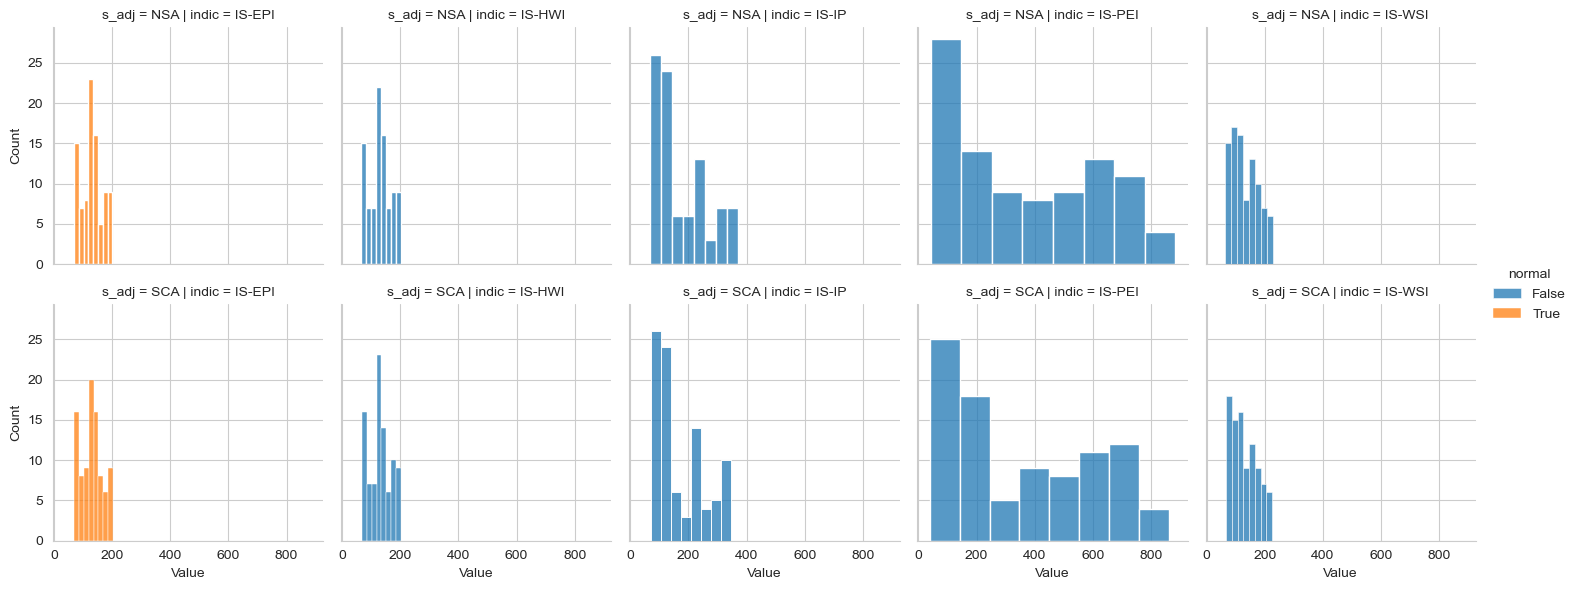

In [89]:
# Create histomgrams of the Value column for the IE dataframe grouped by 'indic' and 's_adj', faceted by the 'normal' column
sns.FacetGrid(IE, col='indic', row='s_adj', hue='normal').map(sns.histplot, 'Value').add_legend()

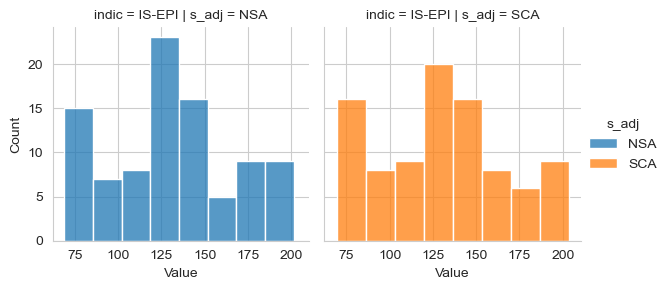

In [90]:
# Create histograms of the Value column for the IE dataframe grouped by 'indic' and 's_adj', where the 'normal' column is True
sns.FacetGrid(IE[IE['normal'] == True], row='indic', col='s_adj', hue= 's_adj').map(sns.histplot, 'Value').add_legend()

Text(0.5, 0.98, 'Boxplots of Value Indexs for Ireland')

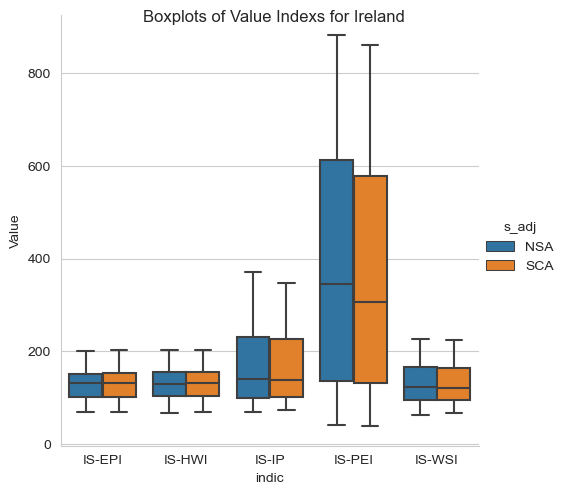

In [91]:
# Create boxplots, splitting the data by indicators and seasonanal adjustment, with a title
sns.catplot(x="indic", y="Value", hue="s_adj", kind="box", data=IE).fig.suptitle('Boxplots of Value Indexs for Ireland')

Perform Statistical Tests

In [92]:
df.groupby(['s_adj','geo\\TIME_PERIOD','indic'])['Value'].apply(lambda x: x.quantile([0.025, 0.975])).unstack()

#For each geo\TIME_PERIOD and indic, calculate the 95% confidence interval for the Value column
df.groupby(['s_adj','geo\\TIME_PERIOD','indic'])['Value'].apply(lambda x: x.quantile([0.025, 0.975])).unstack()

0.025      0.975
s_adj geo\TIME_PERIOD indic                     
NSA   AL              IS-EPI  64.5100   126.4575
                      IS-IP   36.3750   191.1700
                      IS-IPI  86.6075   109.5650
                      IS-PEI  16.7000  2788.3150
                      IS-WSI  32.3775   161.6700
...                               ...        ...
SCA   TR              IS-EPI  49.5400   161.5600
                      IS-HWI  51.6800   170.3000
                      IS-IP   64.2550   103.5850
                      IS-PEI  17.1000   159.8200
                      IS-WSI  29.6400   495.7000

[410 rows x 2 columns]

In [93]:
# Calculate confidence intervals for the IE dataframe grouped by 'indic' and 's_adj'
IE.groupby(['indic', 's_adj'])['Value'].apply(lambda x: x.quantile([0.025, 0.975])).unstack()

0.025     0.975
indic  s_adj                   
IS-EPI NSA    76.1550  200.1250
       SCA    75.2750  199.7475
IS-HWI NSA    72.8400  200.9550
       SCA    71.8775  200.0900
IS-IP  NSA    70.4000  346.7625
       SCA    76.6025  345.3350
IS-PEI NSA    44.8875  786.4000
       SCA    44.7575  799.8850
IS-WSI NSA    72.0750  216.4225
       SCA    71.8950  211.1325

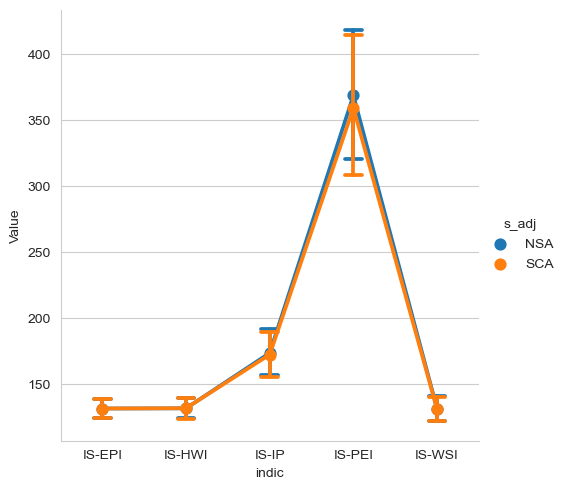

In [94]:
# Create confidence interval plots for the IE dataframe grouped by 'indic' and 's_adj'
sns.catplot(x="indic", y="Value", hue="s_adj", kind="point", data=IE, capsize=.2);

Perform a T-test

In [95]:
# Compare the Number of persons employed index, non-seasonally adjusted, for Ireland and EU28 using a t-test

# Filter the DataFrame to only include rows with geo\TIME_PERIOD values of 'EU28' and 'IE',
# 'IS-EPI' for indic, and 'NSA' for s_adj
df_t = df[(df['geo\\TIME_PERIOD'].isin(['EU28', 'IE'])) & (df['indic'] == 'IS-EPI') & (df['s_adj'] == 'NSA')]

#Filter out Quarters before 1996 and after 2019
df_t = df_t[(df_t['Quarter'] >= '2000Q1') & (df_t['Quarter'] <= '2019Q4')]

# Split the DataFrame into two separate DataFrames, one for each geo\TIME_PERIOD value
df_eu28 = df_t[df_t['geo\\TIME_PERIOD'] == 'EU28']
df_ie = df_t[df_t['geo\\TIME_PERIOD'] == 'IE']

# 

In [96]:
from scipy.stats import levene

# Test samples df_eu28 and df_ie for equal variances
statistic, p_value = levene(df_eu28['Value'], df_ie['Value'])
alpha = 0.05  # significance level

if p_value < alpha:
    print("Reject null hypothesis: Samples have different variances.")
else:
    print("Fail to reject null hypothesis: Samples have equal variances.")
    
# print the statistic and p-value
print('Test Statistic:', round(statistic, 2))

print('p-value:', round(p_value, 2))


Reject null hypothesis: Samples have different variances.
Test Statistic: 87.66
p-value: 0.0


In [97]:
# calculate the sample means and standard deviations
mean_eu28, mean_ie = df_eu28['Value'].mean(), df_ie['Value'].mean()
std_eu28, std_ie = df_eu28['Value'].std(), df_ie['Value'].std()

# Print the sample means and standard deviations
print('EU28: mean=%.3f stdv=%.3f' % (mean_eu28, std_eu28))
print('IE: mean=%.3f stdv=%.3f' % (mean_ie, std_ie))

# Perform the t-test - note that we set equal_var=False as we have already tested for equal variances
t_stat, p_val = ttest_ind(df_eu28['Value'], df_ie['Value'], equal_var=False)

print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_val:.4f}")

# Calculate the degrees of freedom using the Welch-Satterthwaite equation
df_eu28 = len(df_eu28['Value'])
df_ie = len(df_ie['Value'])
dof = (std_eu28**2 / df_eu28 + std_ie**2 / df_ie)**(2.0) / (std_eu28**4 / (df_eu28**2 * (df_eu28 - 1)) + std_ie**4 / (df_ie**2 * (df_ie - 1)))

# Print the degrees of freedom
print(f"Degrees of Freedom: {dof:.4f}")

# Calculate the critical t-value
from scipy.stats import t
alpha = 0.05
cv = t.ppf(1.0 - alpha, dof)

# Print the critical t-value
print(f"Critical t-value: {cv:.4f}")

# Print the p-value and whether or not the null hypothesis is rejected
if abs(t_stat) <= cv:
    print(f"Fail to reject the null hypothesis: the difference between the means is statistically insignificant.")
else:
    print(f"Reject the null hypothesis: the difference between the means is statistically significant.")


EU28: mean=111.188 stdv=8.261
IE: mean=129.128 stdv=38.590
t-statistic: -3.9628
p-value: 0.0002
Degrees of Freedom: 81.8601
Critical t-value: 1.6637
Reject the null hypothesis: the difference between the means is statistically significant.


Perform a One-Way ANOVA

In [98]:
# Filter the dataframe to only include rows where the normal column equals True and the indic column equals 'IS-EPI' and the s_adj column equals 'NSA', and the geo\TIME_PERIOD column equals 'IE', 'EU28' or 'DK'
df_Anova = df[(df['normal'] == True) & (df['indic'] == 'IS-EPI') & (df['s_adj'] == 'NSA') & (df['geo\\TIME_PERIOD'].isin(['IE', 'EU28', 'DK']))]

# Fill in missing values using interpolation
df_Anova['Value'] = df_Anova['Value'].interpolate(both_directions=True)

# Remove all rows before 1996
df_Anova = df_Anova[df_Anova['Quarter'] >= '1996Q1']

C:\Users\Paul\AppData\Local\Temp\ipykernel_58648\1154993261.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [99]:
# Create a list of the unique geo\TIME_PERIOD values
geo_time_periods = df_Anova['geo\\TIME_PERIOD'].unique()

#Make sure the groups have the same sample size
df_Anova['geo\\TIME_PERIOD'].value_counts()

DK      105
EU28    105
IE      105
Name: geo\TIME_PERIOD, dtype: int64

In [100]:
for x in df_Anova['geo\\TIME_PERIOD'].unique():
    print(x, "Mean :", round(df_Anova[df_Anova['geo\\TIME_PERIOD'] == x]['Value'].mean(),2))
    print(x, "Standard Deviation :", round(df_Anova[df_Anova['geo\\TIME_PERIOD'] == x]['Value'].std(),2),'\n')

DK Mean : 118.43
DK Standard Deviation : 17.15 

EU28 Mean : 114.7
EU28 Standard Deviation : 12.52 

IE Mean : 129.52
IE Standard Deviation : 34.91 



In [101]:

#Perform the ANOVA
f_stat, p_val = f_oneway(*[df_Anova[df_Anova['geo\\TIME_PERIOD'] == geo_time_period]['Value'] for geo_time_period in geo_time_periods])

# Show the F-statistic and p-value
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.4f}")

# Show the degrees of freedom for the ANOVA test
print(f"Degrees of freedom: {len(geo_time_periods) - 1}")

#Print th resuts of the ANOVA test
if p_val < 0.05:
    print("Reject null hypothesis - Significant differences exist between groups.")
else:
    print("Accept null hypothesis - No significant difference between groups.")

F-statistic: 11.2046
p-value: 0.0000
Degrees of freedom: 2
Reject null hypothesis - Significant differences exist between groups.


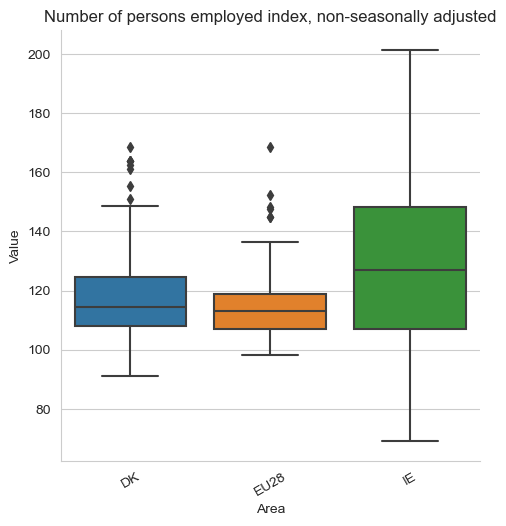

In [102]:
#Show the diferences between the groups using a boxplot
sns.set_style("whitegrid")
sns.catplot(x="geo\\TIME_PERIOD", y="Value", kind="box", data=df_Anova).set_xticklabels(rotation=30)
plt.xlabel('Area')
plt.title('Number of persons employed index, non-seasonally adjusted')
plt.show()



In [103]:
# Perform a Tukey's Range Test to determine which groups are significantly different from each other
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's Range Test
tukey_results = pairwise_tukeyhsd(df_Anova['Value'], df_Anova['geo\\TIME_PERIOD'], 0.05)

# Print the results
print(tukey_results)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
    DK   EU28  -3.7321 0.4864 -11.3992   3.935  False
    DK     IE   11.084 0.0022   3.4169 18.7511   True
  EU28     IE   14.816    0.0   7.1489 22.4831   True
-----------------------------------------------------


Perform a Two-Way ANOVA

In [104]:
# Create a dataframe called prep1 where the indic column equals 'IS-EPI' and the s_adj column contains 'SCA and 'NSA' values and the normal column equals True
twa = df[(df['indic'] == 'IS-EPI') & (df['normal'] == True)]

In [105]:
#Change the name of the geo\TIME_PERIOD column to geo in the df dataframe
twa.rename(columns={'geo\\TIME_PERIOD': 'geo'}, inplace=True)

C:\Users\Paul\AppData\Local\Temp\ipykernel_58648\4015434628.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [106]:
# Filter the dataframe to only include values after 2000 and before 2023
twa = twa[(twa['Quarter'] >= '2000Q1') & (twa['Quarter'] <= '2022Q4')]

In [107]:
# Drop the AT, EL, FI values from the geo column as they don't have the required data
twa = twa[twa['geo'].isin(['IE', 'PL', 'SK'])]

In [108]:
#Make sure the groups have the same sample size
print(twa['geo'].value_counts())

print(twa['s_adj'].value_counts())

IE    176
PL    176
SK    176
Name: geo, dtype: int64
NSA    264
SCA    264
Name: s_adj, dtype: int64


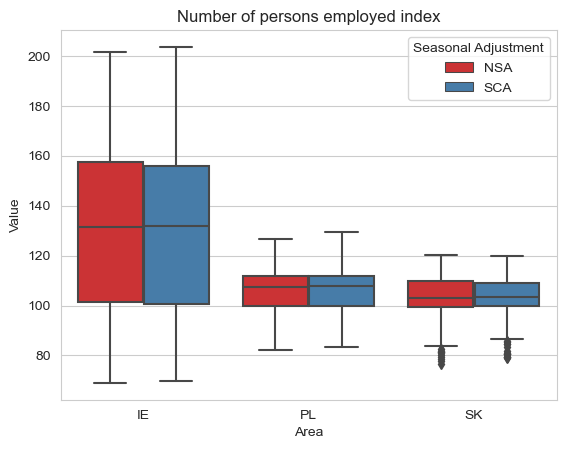

In [109]:
# generate a boxplot to see the data distribution by geo and s_adj
sns.set_style("whitegrid")
sns.boxplot(x="geo", y="Value", hue="s_adj", data=twa, palette="Set1") 
plt.xlabel('Area')
plt.title('Number of persons employed index')
plt.legend(title='Seasonal Adjustment', loc='upper right')
plt.show()

In [110]:
# Print the mean and standard deviation for each geo and s_adj combination
for x in twa['geo'].unique():
    for y in twa['s_adj'].unique():
        print(x, y, "Mean :", round(twa[(twa['geo'] == x) & (twa['s_adj'] == y)]['Value'].mean(),2))
        print(x, y, "Standard Deviation :", round(twa[(twa['geo'] == x) & (twa['s_adj'] == y)]['Value'].std(),2),'\n')

IE NSA Mean : 132.08
IE NSA Standard Deviation : 37.11 

IE SCA Mean : 132.07
IE SCA Standard Deviation : 37.07 

PL NSA Mean : 106.56
PL NSA Standard Deviation : 10.22 

PL SCA Mean : 106.57
PL SCA Standard Deviation : 10.21 

SK NSA Mean : 101.9
SK NSA Standard Deviation : 11.26 

SK SCA Mean : 101.88
SK SCA Standard Deviation : 11.14 



In [111]:
# Perform two-way ANOVA
# The effect of seasonality, the effect of country, and the interaction between seasonality and country
model = ols('Value ~ s_adj + geo + s_adj:geo', data = twa).fit()
aov2 = sm.stats.anova_lm(model, type=2)
print(aov2, '\n')

# print the results of the two-way ANOVA hypothesis tests
print(f"Seasonality p-value: {aov2['PR(>F)'][0]:.4f}")
print(f"Country p-value: {aov2['PR(>F)'][1]:.4f}")
print(f"Interaction p-value: {aov2['PR(>F)'][2]:.4f}", '\n')

# Print the results of the two-way ANOVA hypothesis tests
if aov2['PR(>F)'][0] < 0.05:
    print("Reject null hypothesis - Significant differences exist between Seasonality groups.")
else:
    print("Accept null hypothesis - No significant difference between Seasonality groups.")
    
if aov2['PR(>F)'][1] < 0.05:
    print("Reject null hypothesis - Significant differences exist between Country groups.")
else:
    print("Accept null hypothesis - No significant difference between Country groups.")
    
if aov2['PR(>F)'][2] < 0.05:
    print("Reject null hypothesis - Interaction occurs between factors.")
else:
    print("Accept null hypothesis - No interaction occurs between factors.") 

              df         sum_sq       mean_sq          F        PR(>F)
s_adj        1.0       0.004261      0.004261   0.000008  9.977496e-01
geo          2.0   92911.584356  46455.792178  86.805146  2.847577e-33
s_adj:geo    2.0       0.010341      0.005170   0.000010  9.999903e-01
Residual   522.0  279360.436023    535.173249        NaN           NaN 

Seasonality p-value: 0.9977
Country p-value: 0.0000
Interaction p-value: 1.0000 

Accept null hypothesis - No significant difference between Seasonality groups.
Reject null hypothesis - Significant differences exist between Country groups.
Accept null hypothesis - No interaction occurs between factors.


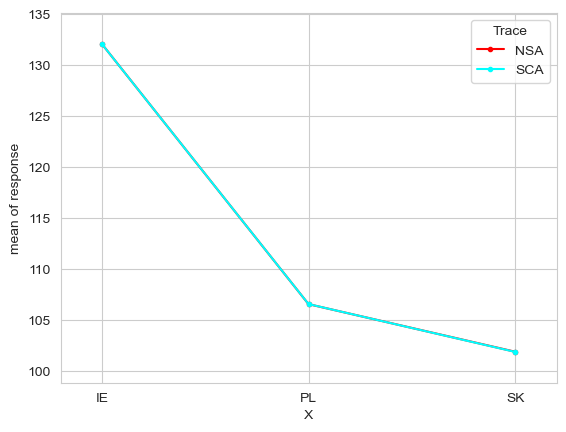

In [112]:
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt

fig = interaction_plot(x=twa['geo'].values, trace=twa['s_adj'].values, response=twa['Value'].values)
plt.show()


In [113]:
# Perform a Tukey's Range Test to determine which groups are significantly different from each other
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's Range Test
tukey_results = pairwise_tukeyhsd(twa['Value'], twa['geo'], 0.05)

# Print the results
print(tukey_results)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
    IE     PL  -25.508   0.0 -31.2876 -19.7283   True
    IE     SK -30.1858   0.0 -35.9654 -24.4062   True
    PL     SK  -4.6778 0.139 -10.4575   1.1018  False
-----------------------------------------------------


In [114]:
# Perform a Tukey's Range Test to determine which groups are significantly different from each other
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's Range Test
tukey_results = pairwise_tukeyhsd(twa['Value'], twa['s_adj'], 0.05)

# Print the results
print(tukey_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
   NSA    SCA  -0.0057 0.998 -4.5545 4.5431  False
--------------------------------------------------


Perform a Wilcoxon Signed-Rank Test

In [115]:
# Find countries that have false values for the normal column where the indic column equals 'IS-HWI'
df[(df['normal'] == False) & (df['indic'] == 'IS-HWI') & (df['s_adj'] == 'NSA')]['geo\\TIME_PERIOD'].unique()

array(['BE', 'BG', 'CY', 'EA19', 'EA20', 'EE', 'ES', 'FI', 'HR', 'IE',
       'IT', 'LT', 'LV', 'ME', 'MK', 'MT', 'NL', 'NO', 'PT', 'SE', 'TR'],
      dtype=object)

In [116]:
# Filter the data
df_WSRT = df.loc[(df['normal'] == False) & (df['indic'] == 'IS-HWI') & (df['s_adj'] == 'NSA')]

# Fliter for quarters after 1996
df_WSRT = df_WSRT[(df_WSRT['Quarter'] >= '2000Q1') & (df_WSRT['Quarter'] <= '2022Q4')]

# Filter Countries with missing values
df_WSRT = df_WSRT[~df_WSRT['geo\\TIME_PERIOD'].isin(['MK', 'TR', 'NL', 'EU28'])]

In [117]:
# View the remaining eligible countries
df_WSRT['geo\\TIME_PERIOD'].unique()

array(['BE', 'BG', 'CY', 'EA19', 'EA20', 'EE', 'ES', 'FI', 'HR', 'IE',
       'IT', 'LT', 'LV', 'ME', 'MT', 'NO', 'PT', 'SE'], dtype=object)

In [118]:
# Select the two groups to compare
df_WSRT[df_WSRT['geo\\TIME_PERIOD'] == 'IE']['Value']
df_WSRT[df_WSRT['geo\\TIME_PERIOD'] == 'IT']['Value']

34499    107.6
34909    118.8
35319    110.1
35729    112.3
36139    106.1
         ...  
68529    129.9
68939    127.8
69349    137.9
69759    127.1
70169    135.1
Name: Value, Length: 88, dtype: float64

In [119]:
# Ensure the two groups have the same sample size
len(df_WSRT[df_WSRT['geo\\TIME_PERIOD'] == 'IE']['Value']), len(df_WSRT[df_WSRT['geo\\TIME_PERIOD'] == 'IT']['Value'])

(88, 88)

In [120]:
# Create Boxplot Data
bp = df_WSRT

bp = bp[bp['geo\\TIME_PERIOD'].isin(['IE', 'IT'])]

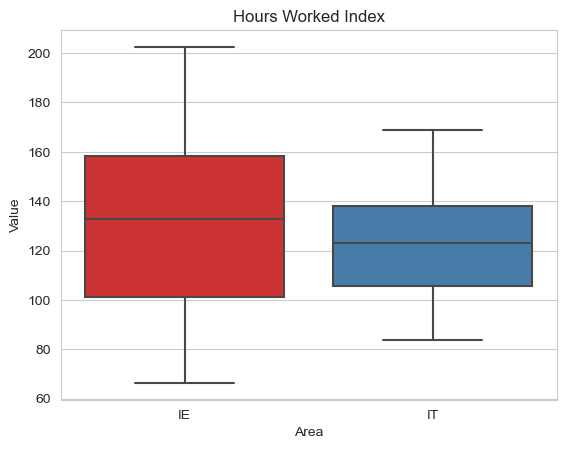

In [121]:
# Visualise the data distribution
sns.set_style("whitegrid")
sns.boxplot(x="geo\\TIME_PERIOD", y="Value", data=bp, palette="Set1")
plt.title('Hours Worked Index')
plt.xlabel('Area')
plt.show()

In [122]:
from scipy.stats import norm

# Null hypothesis: The distribution of group 1 is equal to the distribution of group 2
# Alternative hypothesis: The distribution of group 1 is not equal to the distribution of group 2

# Create a hypothesis function
def hypothesis_test(group1, group2, alpha):
    # Perform Wilcoxon signed-rank test
    stat, p = wilcoxon(group1, group2, alternative='two-sided')

    # Print the results
    print('Wilcoxon signed-rank test:')
    print(f'statistic: {stat:.4f}')
    print(f'p-value: {p:.4f}')

    # print the critical value for the significance level of 0.05
    print(f'critical value: {norm.ppf(1-alpha/2):.4f}')

    # print wheter to reject or accept the null hypothesis
    if p < alpha:
        print('Reject null hypothesis')
    else:
        print('Accept null hypothesis')
        
# 

In [123]:
hypothesis_test(df_WSRT[df_WSRT['geo\\TIME_PERIOD'] == 'IE']['Value'], df_WSRT[df_WSRT['geo\\TIME_PERIOD'] == 'IT']['Value'], 0.05)

Wilcoxon signed-rank test:
statistic: 1300.5000
p-value: 0.0062
critical value: 1.9600
Reject null hypothesis


Perform a Kruskall Wallis Test

In [124]:
# Filter the data
df_kw = df[(df['indic'] == 'IS-HWI') & (df['normal'] == False) & (df['s_adj'] == 'NSA')]

# Filter for quarters after 1996
df_kw = df_kw[(df_kw['Quarter'] >= '2000Q1') & (df_kw['Quarter'] <= '2022Q4')]

# Filter For Ireland, Italy and Finland
df_kw = df_kw[df_kw['geo\\TIME_PERIOD'].isin(['IE', 'IT', 'FI'])]

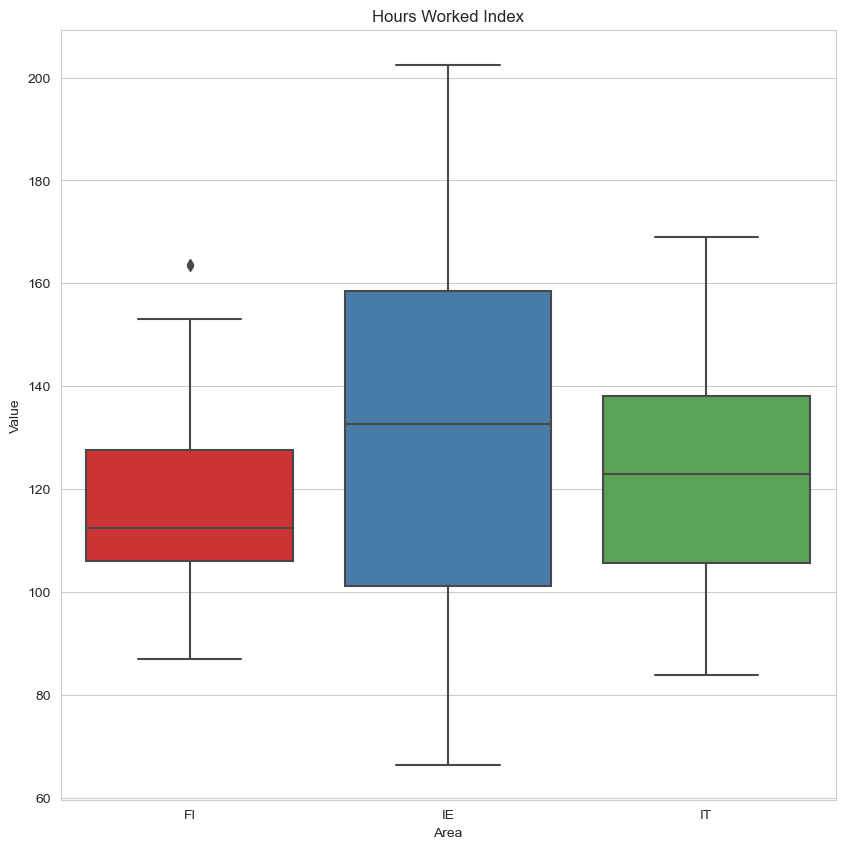

In [180]:
# visualise the data distribution
sns.set_style("whitegrid")
sns.boxplot(x="geo\\TIME_PERIOD", y="Value", data=df_kw, palette="Set1")
plt.title('Hours Worked Index')
plt.xlabel('Area')
plt.show()

In [126]:
# Perform Kruskal-Wallis test
stat, p = kruskal(*[df_kw[df_kw['geo\\TIME_PERIOD'] == geo]['Value'] for geo in df_kw['geo\\TIME_PERIOD'].unique()])

# Print the results
print("Kruskal-Wallis Test Results:")
print(f"Test statistic: {stat:.4f}")
print(f"P-value: {p:.4f}")

# Calculate the critical value for the significance level of 0.05
from scipy.stats import chi2
critical_value = chi2.ppf(1-0.05, 2)

print(f"Critical value: {critical_value:.4f}")

Kruskal-Wallis Test Results:
Test statistic: 8.9346
P-value: 0.0115
Critical value: 5.9915


In [127]:
# Perform post-hoc test
sp.posthoc_dunn([df_kw[df_kw['geo\\TIME_PERIOD'] == geo]['Value'] for geo in df_kw['geo\\TIME_PERIOD'].unique()], p_adjust='holm')

,1,2,3
1,1.000000,0.008443,0.227066
2,0.008443,1.000000,0.227066
3,0.227066,0.227066,1.000000


Machine Learning

Sentiment Analysis

In [128]:
# Load from the .env
load_dotenv()

# Get the environmental variables
APP_NAME = getenv('APP_NAME')
APP_ID = getenv("APP_ID")
APP_SECRET = getenv("APP_SECRET")
USERNAME = getenv('REDDIT_USERNAME')
PASSWORD = getenv('PASSWORD')

In [129]:
# Set up reddit API credentials
reddit = praw.Reddit(
    client_id=APP_ID,
    client_secret=APP_SECRET,
    user_agent=APP_NAME,
    username=USERNAME,
    password=PASSWORD,
)

# Define the subreddits and search query
subreddits = ["Ireland", "Europe"]
query = "house prices"

# Collect posts from the subreddits related to the search query
posts = []
for subreddit_name in subreddits:
    subreddit = reddit.subreddit(subreddit_name)
    for post in subreddit.search(query):
        posts.append(
            {
                "subreddit": subreddit_name,
                "title": post.title,
                "text": post.selftext,
            }
        )

# Convert the collected posts into a dataframe
df_posts = pd.DataFrame(posts)

# Perform sentiment analysis on the collected posts
df_posts["polarity"] = df_posts["text"].apply(lambda x: TextBlob(x).sentiment.polarity)

# Group the results by subreddit and calculate the mean polarity
results = df_posts.groupby("subreddit")["polarity"].mean()

# Print the results
print(results)


subreddit
Europe     0.02144
Ireland    0.04808
Name: polarity, dtype: float64


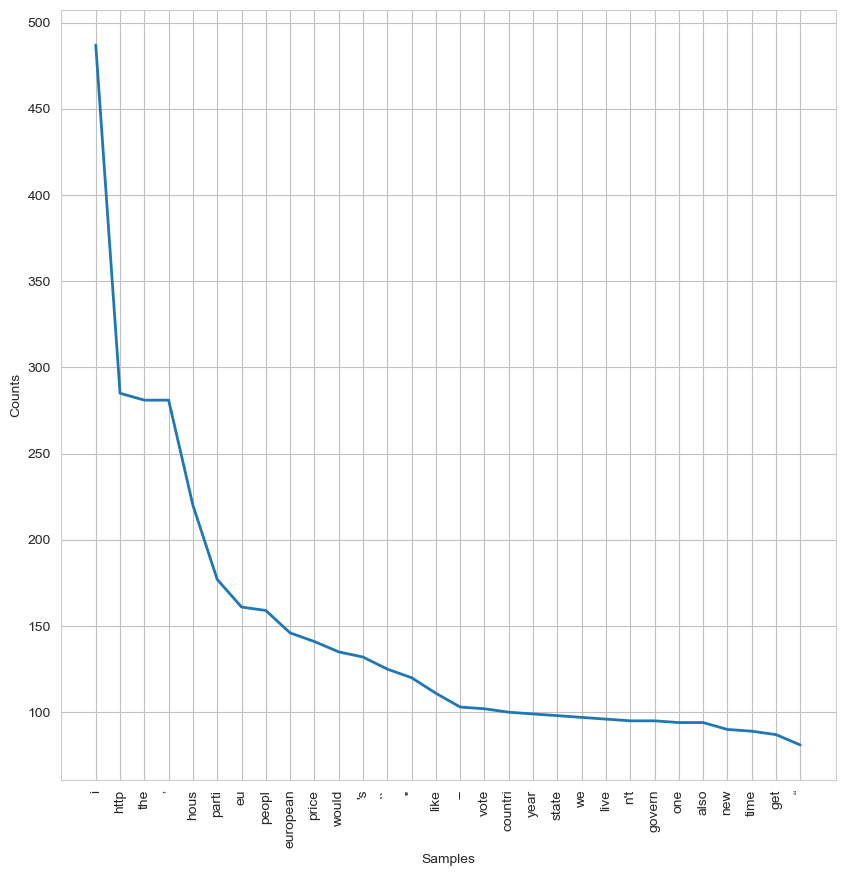

c:\Users\Paul\anaconda3\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



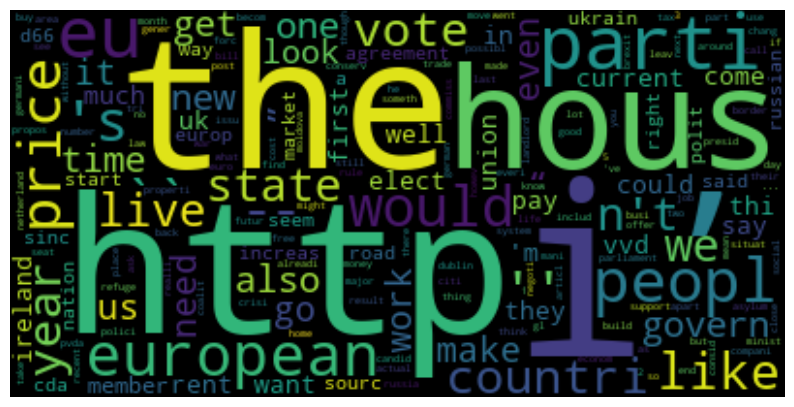

In [182]:
# Use NLTK to tokenize the text
from nltk.tokenize import word_tokenize

# Tokenize the text
tokens = word_tokenize(df_posts["text"].str.cat(sep=" "))
tokens[:10]

# Remove punctuation
import string

# Create a list of punctuation marks
punctuation = string.punctuation

# Remove punctuation from the tokens
tokens = [w for w in tokens if w not in punctuation]
tokens[:10]

# Remove stopwords
from nltk.corpus import stopwords

# Create a list of stopwords
stop_words = stopwords.words("english")

# Remove stopwords from the tokens
tokens = [w for w in tokens if w not in stop_words]
tokens[:10]

# Perform stemming
from nltk.stem import PorterStemmer

# Create a stemmer
porter = PorterStemmer()

# Apply the stemmer to the tokens
tokens = [porter.stem(w) for w in tokens]
tokens[:10]

# Create a frequency distribution
from nltk.probability import FreqDist

# Create a frequency distribution
fdist = FreqDist(tokens)

# Print the 10 most common tokens
fdist.most_common(10)

# Visualise the frequency distribution
fdist.plot(30, cumulative=False)

# Create a word cloud
from wordcloud import WordCloud

# Create a word cloud
wordcloud = WordCloud().generate_from_frequencies(fdist)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [131]:
# Interpret the results of the sentiment analysis for the two subreddits individually, showing the title, text and polarity of the highest and lowest polarity posts for each subreddit.
for subreddit_name in subreddits:
    subreddit = reddit.subreddit(subreddit_name)
    print(f"Results for {subreddit_name}:")
    print("Highest polarity post:")
    print(
        df_posts[df_posts["subreddit"] == subreddit_name].sort_values(
            "polarity", ascending=False
        ).iloc[0]
    )
    print("Lowest polarity post:")
    print(
        df_posts[df_posts["subreddit"] == subreddit_name].sort_values(
            "polarity", ascending=True
        ).iloc[0]
    )
    print("\n")

Results for Ireland:
Highest polarity post:
subreddit                                              Ireland
title        If you were to settle down in any county in Ir...
text         P.S disregard any housing crisis, prices etc e...
polarity                                                   0.9
Name: 92, dtype: object
Lowest polarity post:
subreddit                                              Ireland
title        I was looking to buy a house on daft and the s...
text         The price was shown on the ad and now it just ...
polarity                                               -0.3125
Name: 18, dtype: object


Results for Europe:
Highest polarity post:
subreddit                                               Europe
title        Where in Europe would you want to live your wh...
text         Where in Europe would you want to live your wh...
polarity                                              0.259366
Name: 194, dtype: object
Lowest polarity post:
subreddit                             

In [132]:
# Print if the r/Ireland subreddit is positive or negative
if results["Ireland"] > 0:
    print("The r/Ireland subreddit is positive.")
else:
    print("The r/Ireland subreddit is negative.")
    
# Print if the r/Europe subreddit is positive or negative
if results["Europe"] > 0:
    print("The r/Europe subreddit is positive.")
else:
    print("The r/Europe subreddit is negative.")

The r/Ireland subreddit is positive.
The r/Europe subreddit is positive.


In [133]:
# Interpret the results of the sentiment analysis, showing the sentiment polarity of each subreddit
if results["Ireland"] > results["Europe"]:
    print("The sentiment of the posts from r/Ireland is more positive than the sentiment of the posts from r/Europe.")
    print(f"r/Ireland: {results['Ireland']:.4f}")
    print(f"r/Europe: {results['Europe']:.4f}")
elif results["Ireland"] < results["Europe"]:
    print("The sentiment of the posts from r/Ireland is more negative than the sentiment of the posts from r/Europe.")
    print(f"r/Ireland: {results['Ireland']:.4f}")
    print(f"r/Europe: {results['Europe']:.4f}")
else:
    print("The sentiment of the posts from r/Ireland is the same as the sentiment of the posts from r/Europe.")
    print(f"r/Ireland: {results['Ireland']:.4f}")
    print(f"r/Europe: {results['Europe']:.4f}")


The sentiment of the posts from r/Ireland is more positive than the sentiment of the posts from r/Europe.
r/Ireland: 0.0481
r/Europe: 0.0214


Time Series Analysis

Time Series Analysis 1.1
Data preprocessing

In [134]:
# Filter the DataFrame based on the conditions
df_split = df[(df['indic'] == 'IS-HWI') & (df['normal'] == False) & (df['s_adj'] == 'NSA')].copy()

#Create a df named df_split that contains only the Quarter, Value and geo\TIME_PERIOD columns
df_split = df_split[['Quarter', 'Value', 'geo\\TIME_PERIOD']]

# Filter the DataFrame so only quarters from 2002 or later are included 
df_split = df_split[df_split['Quarter'] >= '2002-01-01']

df_split = df_split[df_split['Quarter'] < '2023-01-01']

# Use interpolation to fill in missing values
df_split['Value'] = df_split['Value'].interpolate(limit_direction='both')

# Define a function to parse the date string
def parse_quarter(date_string):
    year, quarter = date_string.split('-Q')
    month = (int(quarter) - 1) * 3 + 1
    return datetime(int(year), month, 1)

#Apply the parse_quarter function to the 'Quarter' column
df_split['Quarter'] = df_split['Quarter'].apply(parse_quarter)

# Set the 'Quarter' column as the index
df_split.set_index('Quarter', inplace=True)

In [135]:
# Create a list of the unique values in the geo\TIME_PERIOD column
geo_list = df_split['geo\\TIME_PERIOD'].unique()

# Print unique values of the geo\TIME_PERIOD column
print(df_split['geo\\TIME_PERIOD'].unique())

['BE' 'BG' 'CY' 'EA19' 'EA20' 'EE' 'ES' 'FI' 'HR' 'IE' 'IT' 'LT' 'LV' 'ME'
 'MK' 'MT' 'NL' 'NO' 'PT' 'SE' 'TR']


In [136]:
# Split the data into separate countries
for country in df_split['geo\\TIME_PERIOD'].unique():
    exec('{} = df_split[df_split["geo\\TIME_PERIOD"] == country]["Value"]'.format(country))

Time Series Analysis 1.2
Ireland

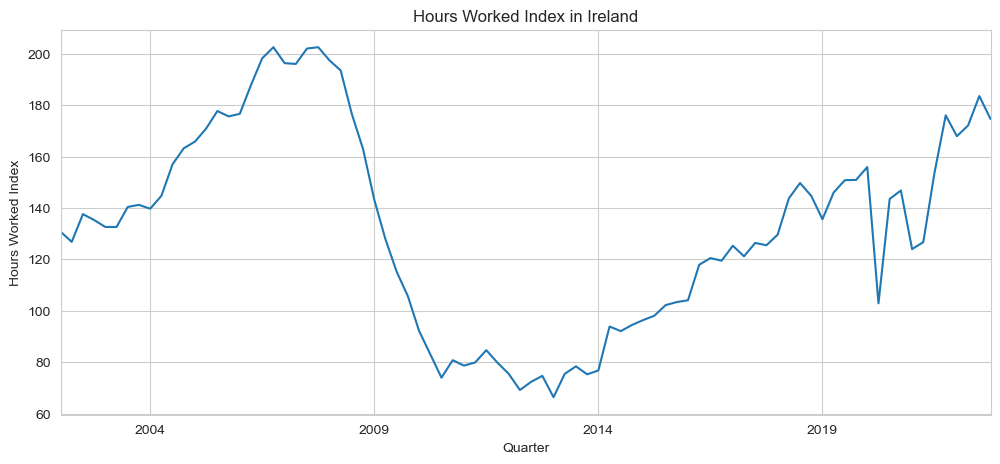

In [184]:
# Create a time series plot of the 'Value' column
IE.plot(figsize=(12, 5))

# Add a title
plt.title('Hours Worked Index in Ireland')

# Add a y-axis label
plt.ylabel('Hours Worked Index')

# Show the plot
plt.show()

In [138]:
IE = IE.asfreq('QS-OCT')

In [139]:
# Covert series to dataframe
df_IE = IE.to_frame()

# Reset the index of df_IE
df_IE.reset_index(inplace=True)

In [140]:
# Create Year and Month columns
df_IE['year'] = [d.year for d in df_IE.Quarter]
df_IE['month'] = [d.strftime('%b') for d in df_IE.Quarter]
years = df_IE['year'].unique()

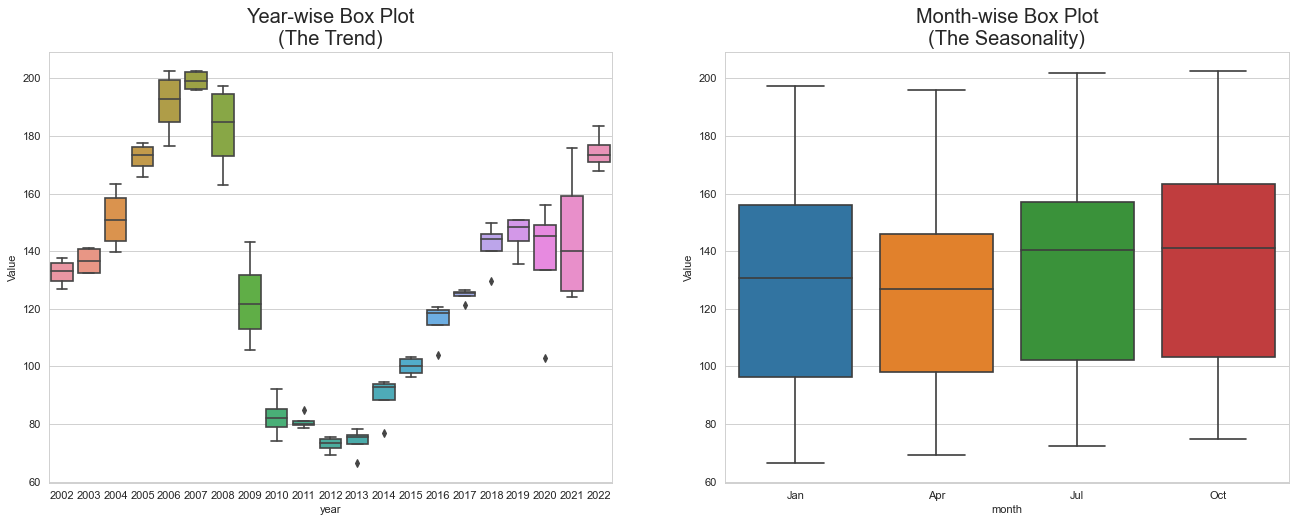

In [141]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='Value', data=df_IE, ax=axes[0])
sns.boxplot(x='month', y='Value', data=df_IE)

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

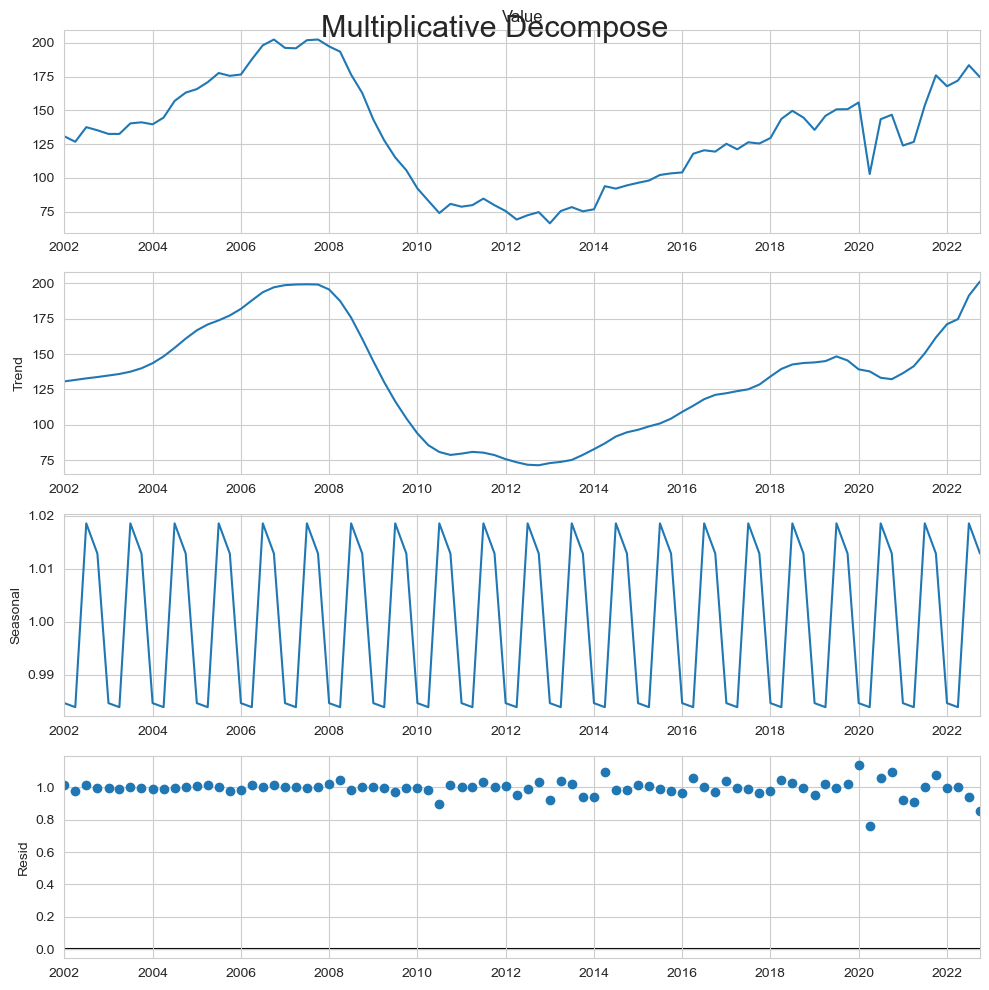

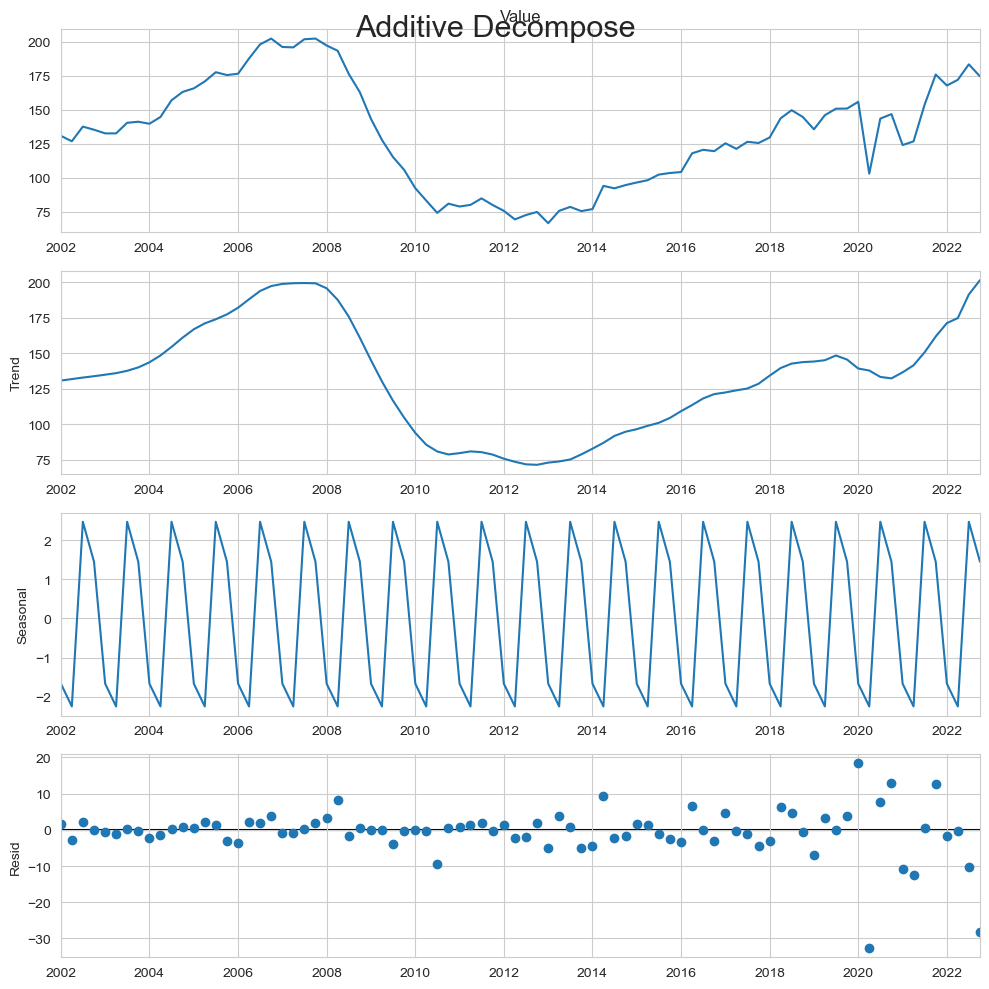

In [142]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(IE, model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(IE, model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [143]:
# Find out if the data is stationary or non-stationary
adf_test = adfuller(IE)
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
print(f'Critical Values: {adf_test[4]}')

ADF Statistic: -2.3252663405606975
p-value: 0.163948501051432
Critical Values: {'1%': -3.517113604831504, '5%': -2.8993754262546574, '10%': -2.5869547797501644}


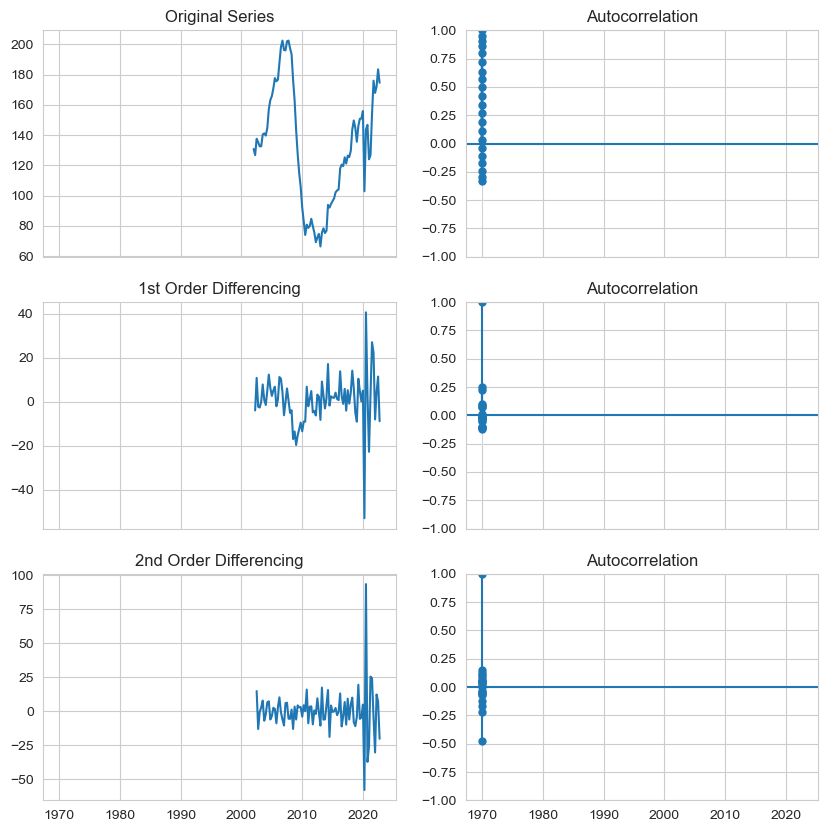

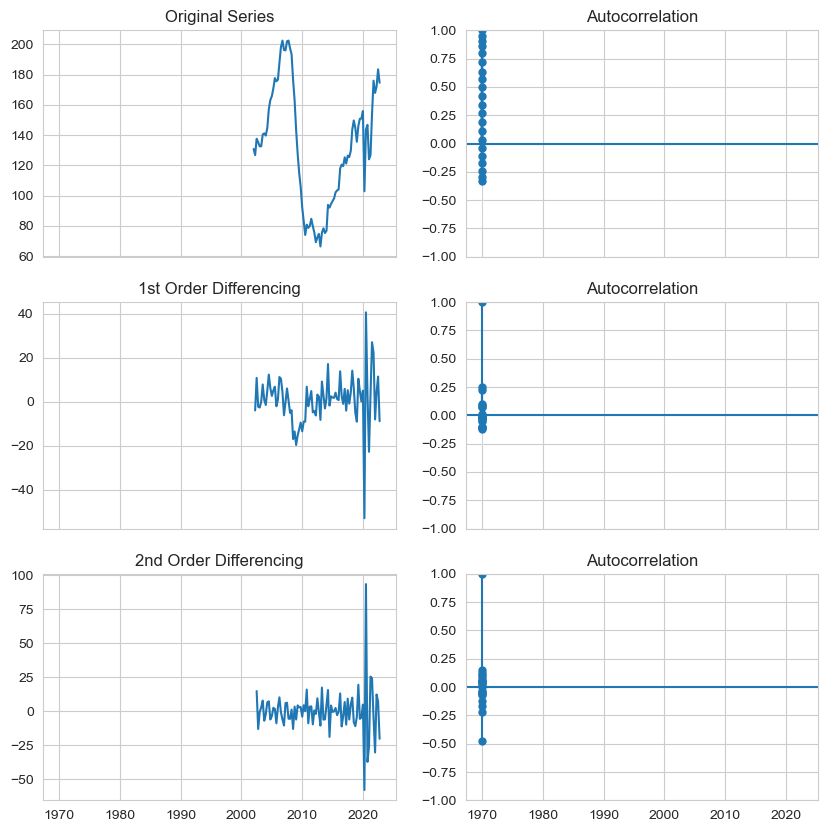

In [144]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(IE); axes[0, 0].set_title('Original Series')
plot_acf(IE, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(IE.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(IE.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(IE.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(IE.diff().diff().dropna(), ax=axes[2, 1])

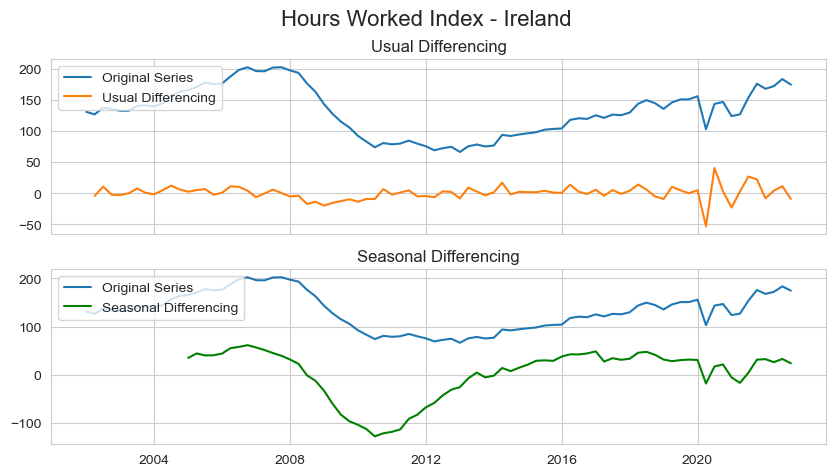

In [145]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(IE[:], label='Original Series')
axes[0].plot(IE[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(IE[:], label='Original Series')
axes[1].plot(IE[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Hours Worked Index - Ireland', fontsize=16)
plt.show()

In [146]:
#Split into train and test sets
train = IE[:len(IE)-12]
test = IE[len(IE)-12:]

2020-01-01    150.684318
2020-04-01    150.468945
2020-07-01    150.253879
2020-10-01    150.039121
2021-01-01    149.824670
2021-04-01    149.610525
2021-07-01    149.396687
2021-10-01    149.183154
2022-01-01    148.969926
2022-04-01    148.757003
2022-07-01    148.544384
2022-10-01    148.332070
Freq: QS-OCT, Name: predicted_mean, dtype: float64


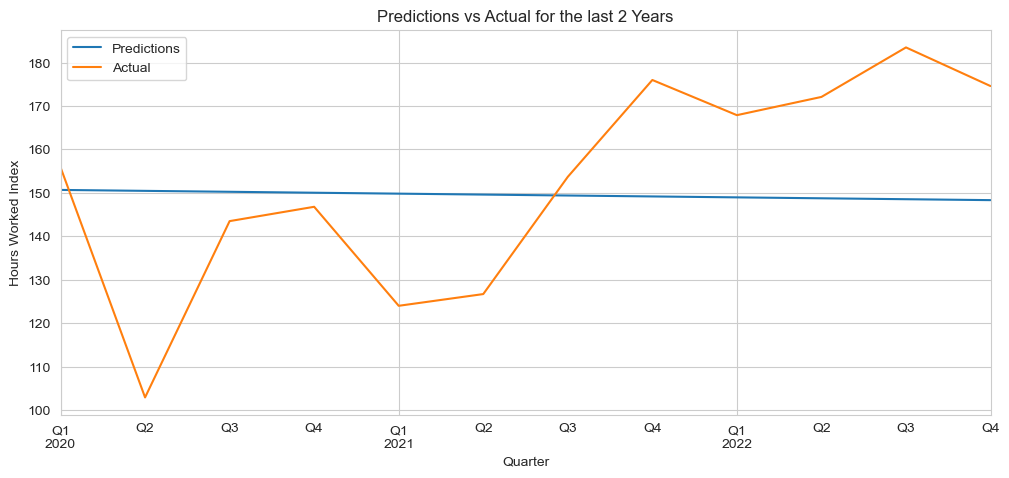

Quarter
2020-01-01    155.9
2020-04-01    102.9
2020-07-01    143.5
2020-10-01    146.8
2021-01-01    124.0
2021-04-01    126.7
2021-07-01    153.7
2021-10-01    176.0
2022-01-01    167.9
2022-04-01    172.1
2022-07-01    183.5
2022-10-01    174.6
Freq: QS-OCT, Name: Value, dtype: float64
The MAE is 20.510799901941244
The RMSE is 24.308305472661612


In [147]:
# Suppress warning messages
warnings.filterwarnings("ignore")

# Create a SARIMAX model
model = sm.tsa.statespace.SARIMAX(train)
fit_model = model.fit()

# Generate predictions
predictions = fit_model.predict(start=len(train), end=len(train) + len(test) - 1)

# Print the predictions
print(predictions)

# Plot the predictions
predictions.plot(figsize=(12, 5))

# Plot the actual values
IE[len(IE)-12:].plot()

# Add a title
plt.title('Predictions vs Actual for the last 2 Years')

# Add a y-axis label
plt.ylabel('Hours Worked Index')

# Add a legend
plt.legend(['Predictions', 'Actual'])

# Show the plot
plt.show()

# Print the test data
print(test)

# Print the mean absolute error (MAE)
print('The MAE is', mean_absolute_error(test, predictions))

# Print the root mean squared error (RMSE)
print('The RMSE is', mean_squared_error(test, predictions, squared=False))

In [148]:
# Tune the models hyperparameters to improve the RMSE
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]

# Find the optimal set of parameters that yields the best performance
# Define the initial parameters
best_score, best_params, best_seasonal_params = float("inf"), None, None

# Loop through the parameter combinations
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            # Create a SARIMAX model
            model = sm.tsa.statespace.SARIMAX(train, order=param, seasonal_order=param_seasonal)

            # Fit the model
            results = model.fit()

            # Generate predictions
            predictions = results.predict(start=len(train), end=len(train) + len(test) - 1)

            # Calculate the mean squared error
            mse = mean_squared_error(test, predictions)

            # If the mse is lower than our best score, update the best score, and best parameters
            if mse < best_score:
                best_score, best_params, best_seasonal_params = mse, param, param_seasonal

            # Print the model parameters and the mean squared error
            print('SARIMA{}x{}4 - AIC:{}'.format(param, param_seasonal, mse))
        except:
            continue
        
# Print the best model parameters and the mean squared error
print('Best SARIMA{}x{}4 AIC:{}'.format(best_params, best_seasonal_params, best_score))

# Turn warnings back on
warnings.filterwarnings("default")

SARIMA(0, 0, 0)x(0, 0, 0, 4)4 - AIC:23752.54333333333
SARIMA(0, 0, 0)x(0, 0, 1, 4)4 - AIC:19277.794093184842
SARIMA(0, 0, 0)x(0, 1, 0, 4)4 - AIC:570.0624999999999
SARIMA(0, 0, 0)x(0, 1, 1, 4)4 - AIC:611.8208036480053
SARIMA(0, 0, 0)x(1, 0, 0, 4)4 - AIC:681.3019888993091
SARIMA(0, 0, 0)x(1, 0, 1, 4)4 - AIC:848.275281028344
SARIMA(0, 0, 0)x(1, 1, 0, 4)4 - AIC:505.44204363960466
SARIMA(0, 0, 0)x(1, 1, 1, 4)4 - AIC:583.7703855747419
SARIMA(0, 0, 1)x(0, 0, 0, 4)4 - AIC:22084.650703909836
SARIMA(0, 0, 1)x(0, 0, 1, 4)4 - AIC:18333.048254494886
SARIMA(0, 0, 1)x(0, 1, 0, 4)4 - AIC:528.3830577827063
SARIMA(0, 0, 1)x(0, 1, 1, 4)4 - AIC:545.204872928834
SARIMA(0, 0, 1)x(1, 0, 0, 4)4 - AIC:602.7422476947887
SARIMA(0, 0, 1)x(1, 0, 1, 4)4 - AIC:693.7735900283647
SARIMA(0, 0, 1)x(1, 1, 0, 4)4 - AIC:494.4340987139672
SARIMA(0, 0, 1)x(1, 1, 1, 4)4 - AIC:514.4940281593521
SARIMA(0, 1, 0)x(0, 0, 0, 4)4 - AIC:559.2133333333333
SARIMA(0, 1, 0)x(0, 0, 1, 4)4 - AIC:549.0399749892779
SARIMA(0, 1, 0)x(0, 1, 0, 

2020-01-01    141.8
2020-04-01    152.2
2020-07-01    157.0
2020-10-01    157.1
2021-01-01    148.0
2021-04-01    158.4
2021-07-01    163.2
2021-10-01    163.3
2022-01-01    154.2
2022-04-01    164.6
2022-07-01    169.4
2022-10-01    169.5
Freq: QS-OCT, Name: predicted_mean, dtype: float64


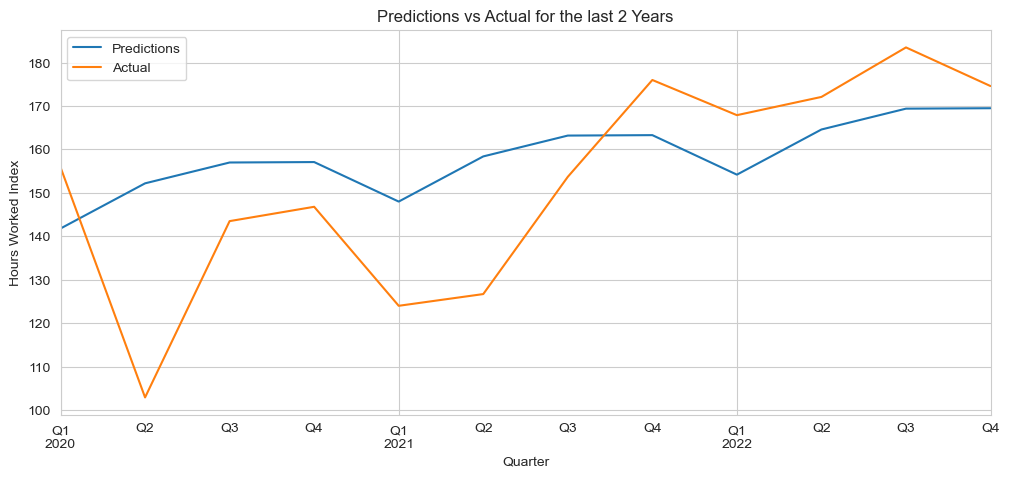

Quarter
2020-01-01    155.9
2020-04-01    102.9
2020-07-01    143.5
2020-10-01    146.8
2021-01-01    124.0
2021-04-01    126.7
2021-07-01    153.7
2021-10-01    176.0
2022-01-01    167.9
2022-04-01    172.1
2022-07-01    183.5
2022-10-01    174.6
Freq: QS-OCT, Name: Value, dtype: float64
The MAE is 17.125000000001737
The RMSE is 20.85431610003014


In [149]:
# Create a tuned model
model1 = sm.tsa.statespace.SARIMAX(train,order=(0, 1, 0), seasonal_order=(0, 1, 0, 4))
fit_model1 = model1.fit()

# Generate predictions
predictions1 = fit_model1.predict(start=len(train), end=len(train) + len(test) - 1)

# Print the predictions
print(predictions1)

# Plot the predictions
predictions1.plot(figsize=(12, 5))

# Plot the actual values
IE[len(IE)-12:].plot()

# Add a title
plt.title('Predictions vs Actual for the last 2 Years')

# Add a y-axis label
plt.ylabel('Hours Worked Index')

# Add a legend
plt.legend(['Predictions', 'Actual'])

# Show the plot
plt.show()

# Print the test data
print(test)

# Print the mean absolute error (MAE)
print('The MAE is', mean_absolute_error(test, predictions1))

# Print the root mean squared error (RMSE)
print('The RMSE is', mean_squared_error(test, predictions1, squared=False))

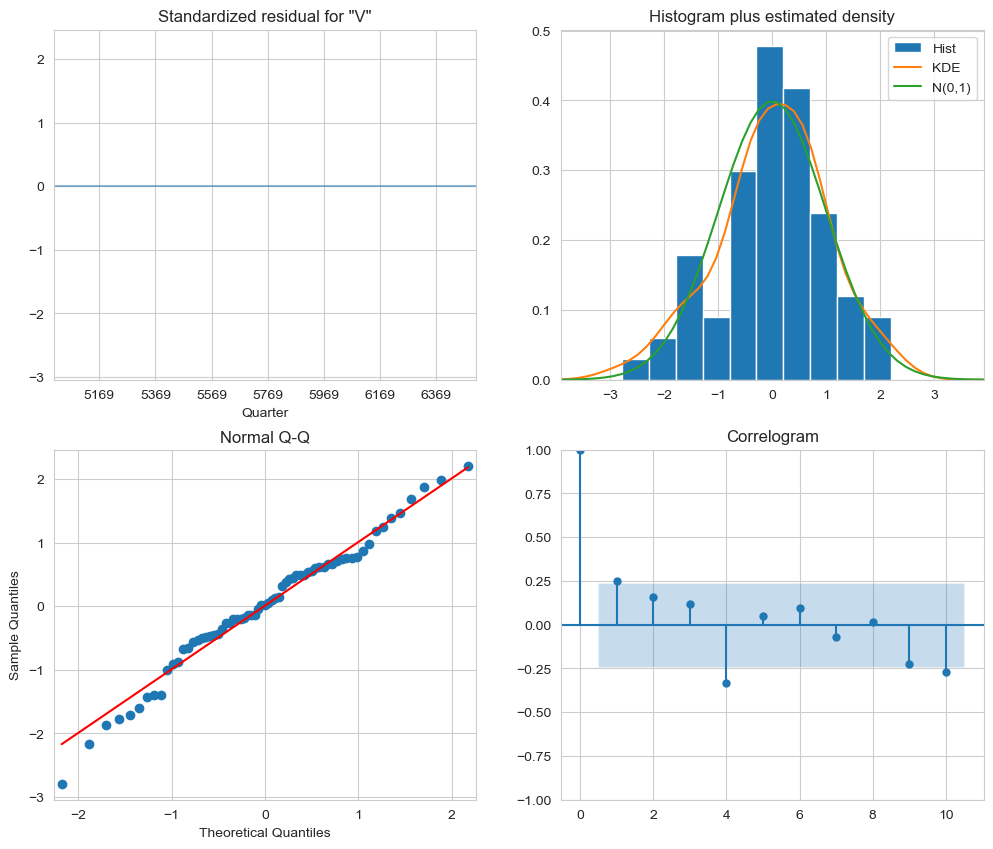

In [150]:
# Visualize the results
fit_model1.plot_diagnostics(figsize=(12, 10))
plt.show()

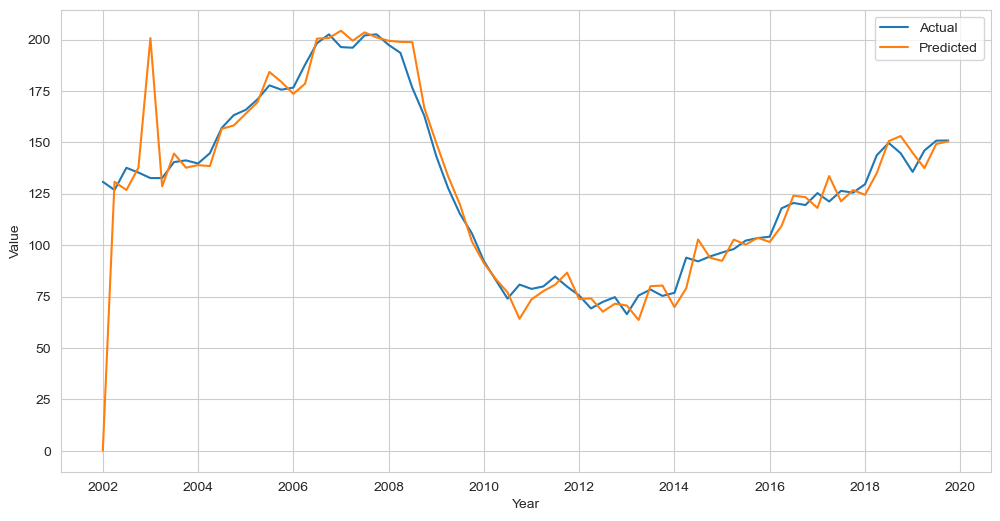

In [151]:
# Get the predicted values
pred = results.predict()

# Plot the actual values and the predicted values
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(IE["2000":"2019"], label='Actual')
ax.plot(pred, label='Predicted')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Value')
plt.show()

In [152]:
# Create a prediction for the next 5 values
pred = results.predict(start=(len(IE)-1), end=(len(IE)) + 4)

# Print the predictions
print(pred)

2022-10-01    177.888528
2023-01-01    176.637728
2023-04-01    183.296991
2023-07-01    186.892098
2023-10-01    186.044040
2024-01-01    184.753059
Freq: QS-OCT, Name: predicted_mean, dtype: float64


Text(0, 0.5, 'Value')

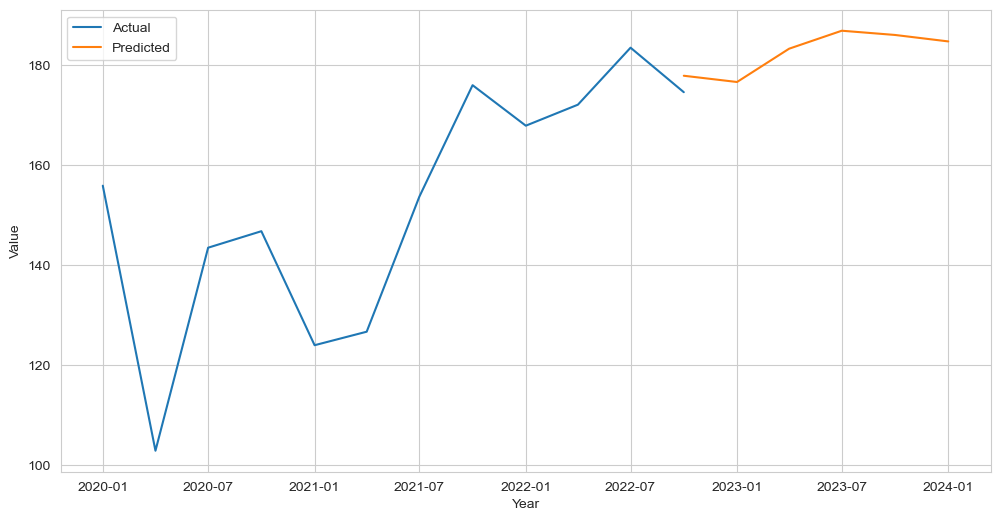

In [153]:
# Plot the Current Year with actual and predicted values and the Next Year with predicted values
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(IE[len(IE)-12:], label='Actual')
ax.plot(pred, label='Predicted')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Value')

Time Series Analysis 1.3 
Across countries

In [154]:
import statsmodels.api as sm

# For each geo_list item, set the freq to 'QS-OCT'
for geo in geo_list:
    globals()[geo].index.freq = 'QS-OCT'

# List of dataframe names
dataframe_names = geo_list

# Create an empty list to store the comparison dataframes
comparison_dataframes = []

# Loop over the dataframe names
for name in dataframe_names:
    # Access the dataframe using the name
    dataframe = globals()[name]
    
    # Split into train and test sets
    train = dataframe[:len(dataframe)-12]
    test = dataframe[len(dataframe)-12:]
    
    # Create a model
    model = sm.tsa.statespace.SARIMAX(train, order=(0, 1, 0), seasonal_order=(0, 1, 0, 4))
    fit_model = model.fit()
    
    # Generate predictions
    predictions = fit_model.predict(start=(len(train)), end=len(train) + len(test) - 1)
    
    # Create a prediction for the next 4 values
    pred = fit_model.predict(start=(len(dataframe)-1), end=len(dataframe) + 3)
    
    # Create a DataFrame of the actual and predicted values
    compare = pd.DataFrame({'Actual': test, 'Predicted': pred})
    compare.name = name
    
    # Append the comparison dataframe to the list
    comparison_dataframes.append(compare)

In [155]:
# Reset the index of the comparison dataframe and rename it to Quarter
comparison_dataframes[0].reset_index(inplace=True)
comparison_dataframes[0].rename(columns={'index': 'Quarter'}, inplace=True)

In [156]:
comp_df = pd.concat([df.assign(geo=name) for name, df in zip(geo_list, comparison_dataframes)], ignore_index=True)

In [157]:
# Create a list of the first 16 Quarter values and apply them to each geo group
quarters = comp_df['Quarter'].unique()[:16]

# Add quarters to each geo group
comp_df['Quarter'] = np.tile(quarters, 21)

Support Vector Regression

Support Vector Regression 1.1
Data Preparation

In [158]:
# Filter the dataframe to only include NSA IS-EPI data
df_svr = df.copy()
df_svr = df_svr[(df_svr['indic'] == 'IS-EPI')]

# Use interpolation to fill in missing values in the Value column
df_svr['Value'] = df_svr['Value'].interpolate(limit_direction='both')

# Filter for values after 1999
df_svr = df_svr[df_svr['Quarter'] >= '1999Q1']

In [159]:
# Scale the 'Value' column
df_svr['Value'] = StandardScaler().fit_transform(df_svr[['Value']])

# select the relevant columns as features and target
X = df_svr[['geo\\TIME_PERIOD', 's_adj']]
y = df_svr['Value']

# perform one-hot encoding on the categorical columns
encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(X)

Support Vector Regression 1.2
Model Fitting

In [160]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2)

# create and fit the model
model = SVR()
model.fit(X_train, y_train)

# make predictions on the test set
y_pred = model.predict(X_test)

# calculate the model's performance metrics
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse)
print("R-squared:", r2)

MSE: 0.7262842555475069
R-squared: 0.295498343794225


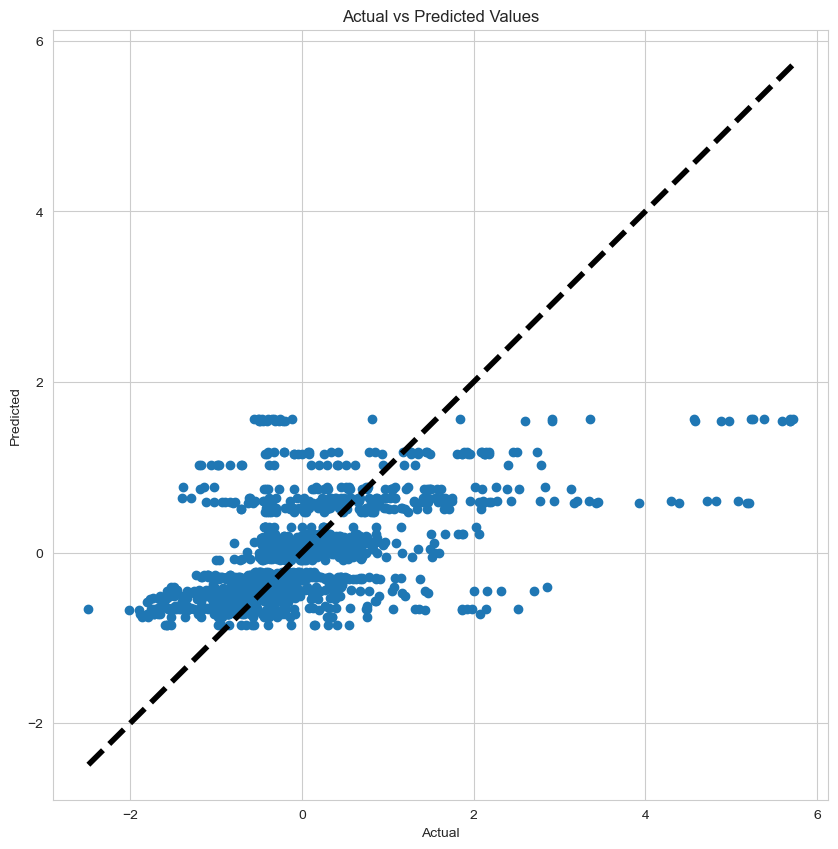

In [161]:
# Plot the actual vs predicted values
plt.scatter(y_test, y_pred)

# Add a diagonal line for comparison
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.show()


Support Vector Regression 1.2
Hyperparameter Tuning

In [162]:
###WAIT###


## Will take 10 minutes to run, {'C': 10, 'gamma': 0.1, 'kernel': 'linear'} is the output

# create a Support Vector Regression object
svr = SVR()

# define the hyperparameter grid to search over
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly']}

# create a GridSearchCV object
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# print the best hyperparameters found
print(grid_search.best_params_)


In [163]:
# Use the best hyperparameters to create a new model
best_svr = SVR(C=10, gamma=0.1, kernel='linear')

# Fit the model to the training data
best_svr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_svr.predict(X_test)

# Calculate the model's performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse)
print("R-squared:", r2)

MSE: 0.7141671942050907
R-squared: 0.3072519922023734


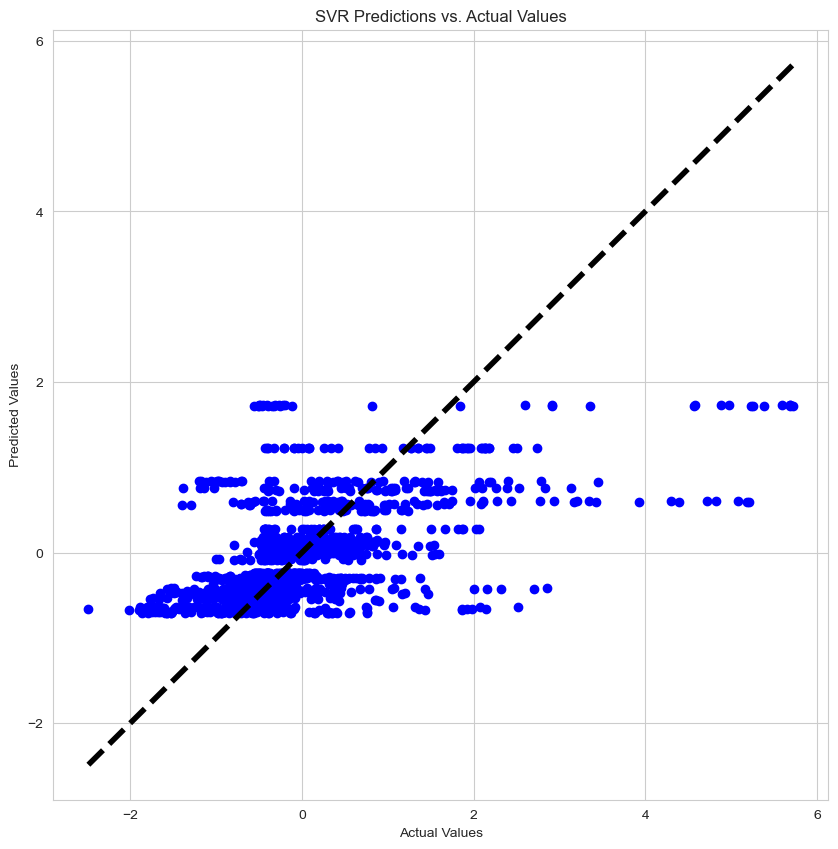

In [164]:
import matplotlib.pyplot as plt

# Plot the actual values and predicted values
plt.scatter(y_test, y_pred, color='blue')

# Add a diagonal line for comparison
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('SVR Predictions vs. Actual Values')

# Show the plot
plt.show()

Interactive Dashboard
- Time Series Analysis Predictions

Dashboard 1.1
Data preprocessing

In [165]:
# Filter the DataFrame based on the conditions
df_filtered = df[(df['indic'] == 'IS-HWI') & (df['normal'] == False) & (df['s_adj'] == 'NSA')].copy()

# Filter the DataFrame so only quarters from 2002 or later are included 
df_filtered = df_filtered[df_filtered['Quarter'] >= '2002-01-01']

In [166]:
# Use interpolation to fill in missing values
df_filtered['Value'] = df_filtered['Value'].interpolate(limit_direction='both')

In [167]:
# Print unique values of the 'Country_Codes' column
print(df_filtered['Country_Codes'].unique())

['BEL' 'BGR' 'CYP' nan 'EST' 'ESP' 'FIN' 'HRV' 'IRL' 'ITA' 'LTU' 'LVA'
 'MNE' 'MKD' 'MLT' 'NLD' 'NOR' 'PRT' 'SWE' 'TUR']


In [168]:
# Print unique values of the 'geo\\TIME_PERIOD' column
print(df_filtered['geo\\TIME_PERIOD'].unique())

['BE' 'BG' 'CY' 'EA19' 'EA20' 'EE' 'ES' 'FI' 'HR' 'IE' 'IT' 'LT' 'LV' 'ME'
 'MK' 'MT' 'NL' 'NO' 'PT' 'SE' 'TR']


In [169]:
# Where the 'Country_Codes' column is null, fill in the value of the 'geo\\TIME_PERIOD' column
df_filtered['Country_Codes'] = df_filtered['Country_Codes'].fillna(df_filtered['geo\\TIME_PERIOD'])

In [170]:
# Define a function to parse the date string
def parse_quarter(date_string):
    year, quarter = date_string.split('-Q')
    month = (int(quarter) - 1) * 3 + 1
    return datetime(int(year), month, 1)

#Apply the parse_quarter function to the 'Quarter' column
df_filtered['Quarter'] = df_filtered['Quarter'].apply(parse_quarter)

In [171]:
# Create a dictionary to map country codes to full names
country_names = {
 "NLD": "Netherlands",
 "LTU": "Lithuania",
 "BEL": "Belgium",
 "BGR": "Bulgaria",
 "CYP": "Cyprus",
 "EST": "Estonia",
 "ESP": "Spain",
 "FIN": "Finland",
 "HRV": "Croatia",
 "IRL": "Ireland",
 "ITA": "Italy",
 "LVA": "Latvia",
 "MNE": "Montenegro",
 "MLT": "Malta",
 "NOR": "Norway",
 "PRT": "Portugal",
 "SWE": "Sweden",
 "TUR": "Turkey",
 "MKD": "North Macedonia",
 "EA19" : "Euro Area (19 countries, 2015-2022)",
 "EA20" : "Euro Area (20 countries from 2023)",
}

# Create a new column in df_filtered with full country names
df_filtered["Country_Names"] = df_filtered["Country_Codes"].map(country_names)

In [172]:
# Remove the EA19 and EA20 rows
df_filtered = df_filtered[df_filtered["geo\\TIME_PERIOD"].isin(["EA19", "EA20"]) == False]

In [173]:
def add_max_column(df_filtered):
    max_values = df_filtered.groupby("Country_Codes")["Value"].transform("max")
    max_indices = df_filtered["Value"] == max_values
    df_filtered["Max"] = df_filtered.loc[max_indices, "Quarter"].dt.strftime("%Y-%m-%d") + " - " + df_filtered.loc[max_indices, "Value"].astype(str)
    return df_filtered

add_max_column(df_filtered)

def add_min_column(df_filtered):
    min_values = df_filtered.groupby("Country_Codes")["Value"].transform("min")
    min_indices = df_filtered["Value"] == min_values
    df_filtered["Min"] = df_filtered.loc[min_indices, "Quarter"].dt.strftime("%Y-%m-%d") + " - " + df_filtered.loc[min_indices, "Value"].astype(str)
    return df_filtered

add_min_column(df_filtered)


,geo\TIME_PERIOD,indic,s_adj,freq,unit,nace_r2,Quarter,Value,Country_Codes,pvalue,normal,Country_Names,Max,Min
36121,BE,IS-HWI,NSA,Q,I2015,F,2002-01-01,97.60,BEL,3.933126e-02,False,Belgium,NaN,NaN
36122,BG,IS-HWI,NSA,Q,I2015,F,2002-01-01,66.90,BGR,1.247375e-07,False,Bulgaria,NaN,NaN
36124,CY,IS-HWI,NSA,Q,I2015,F,2002-01-01,140.30,CYP,8.788795e-03,False,Cyprus,NaN,NaN
36130,EE,IS-HWI,NSA,Q,I2015,F,2002-01-01,68.90,EST,6.030875e-03,False,Estonia,NaN,2002-01-01 - 68.9
36132,ES,IS-HWI,NSA,Q,I2015,F,2002-01-01,138.60,ESP,4.409479e-03,False,Spain,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70586,NL,IS-HWI,NSA,Q,I2015,F,2023-01-01,132.46,NLD,9.571093e-07,False,Netherlands,NaN,NaN
70587,NO,IS-HWI,NSA,Q,I2015,F,2023-01-01,120.58,NOR,3.948446e-03,False,Norway,NaN,NaN
70589,PT,IS-HWI,NSA,Q,I2015,F,2023-01-01,108.70,PRT,5.634062e-103,False,Portugal,NaN,NaN
70592,SE,IS-HWI,NSA,Q,I2015,F,2023-01-01,98.50,SWE,2.019061e-03,False,Sweden,NaN,NaN


In [174]:
# filter out all rows where the 'Max' column is null and assign the result to df_max
df_max = df_filtered[df_filtered['Max'].notnull()]

# filter out all rows where the 'Min' column is null and assign the result to df_min
df_min = df_filtered[df_filtered['Min'].notnull()]

# Merge df_filtered and df_max on the 'Country_Codes' column using a left join, keep only the Max column from df_max and rename it to 'Max'
df_filtered = df_filtered.merge(df_max[['Country_Codes', 'Max']], on='Country_Codes', how='left').rename(columns={'Max': 'Max'})

# Merge df_filtered and df_min on the 'Country_Codes' column using a left join, keep only the Min column from df_min and rename it to 'Min'
df_filtered = df_filtered.merge(df_min[['Country_Codes', 'Min']], on='Country_Codes', how='left').rename(columns={'Min': 'Min'})


In [175]:
geolocator = Nominatim(user_agent="my-app")  # Initialize the geolocator

# country_codes is equal to the unique values of the 'geo\\TIME_PERIOD' column, filtering out EA19 and EA20
country_codes = df_filtered[df_filtered['geo\\TIME_PERIOD'] != 'EA19'][df_filtered['geo\\TIME_PERIOD'] != 'EA20']['geo\\TIME_PERIOD'].unique()

data = {"geo\\TIME_PERIOD": country_codes, "Latitude": [], "Longitude": []}

for country_code in country_codes:
    location = geolocator.geocode(country_code)
    if location is not None:
        data["Latitude"].append(location.latitude)
        data["Longitude"].append(location.longitude)
    else:
        data["Latitude"].append(None)
        data["Longitude"].append(None)

df_coords = pd.DataFrame(data)


In [176]:
# Merge df_filtered and df_coords
df_filtered = df_filtered.merge(
    df_coords[
        [
            'geo\\TIME_PERIOD', 
            'Latitude', 
            'Longitude'
            ]
        ],
    left_on='geo\\TIME_PERIOD',
    right_on='geo\\TIME_PERIOD',
    how='left'
    ).rename(
        columns={
            'Latitude': 'Latitude', 
            'Longitude': 'Longitude'
            }
        )

In [177]:
# Rename geo\\TIME_PERIOD to geo in df_filtered
df_filtered = df_filtered.rename(columns={'geo\\TIME_PERIOD': 'geo'})

# merge the comp_df and df_filtered on geo == geo and keeping all rows from comp_df
df_filtered = comp_df.merge(df_filtered, left_on='geo', right_on='geo', how='left')

In [178]:
# Remove the EA19 and EA20 rows
df_filtered = df_filtered[df_filtered["geo"].isin(["EA19", "EA20"]) == False]

Dashboard 1.2
Create the Dashboard

In [179]:
# Create initial figures
fig_line = px.line(df_filtered, x="Quarter_x", y=["Actual", "Predicted"], color="Country_Codes",template = 'simple_white') 
fig_map = px.choropleth(df_filtered, locations="Country_Codes", color="Value")

# Add another line to fig_line based on Predicted column
fig_line.add_trace(go.Scatter(x=df_filtered["Quarter_x"], y=df_filtered["Predicted"], name="Predicted", mode="lines", line=dict(color="black", dash="dash")))

# Create app layout
app = JupyterDash(__name__) # Use JupyterDash instead of Dash
app.layout = html.Div([
 html.H2(
 "Quarterly Hours Worked Index (Non-Seasonally Adjusted)", 
 id="heading",
 style={"textAlign": "center"}
 ),
 dcc.RadioItems( 
 id="country-buttons", 
 options=[{"label": c, "value": c} for c in df_filtered["Country_Names"].unique()], # Use full country names as labels
 value=df_filtered["Country_Names"].iloc[0],
 style={"table-layout": "fixed", "width": "50%"}, # Style the container element 
 labelStyle={"display": "inline-block", "margin-right": "10px"} # Style each label element
 ),
 html.Div([ # Wrap line chart and map in a div with flex display
     html.Div([ # Wrap dropdown in a div with 50% width
         dcc.Graph(id="map-chart", figure=fig_map)
     ], style={"width": "50%"}),
     html.Div([ # Wrap map in a div with 50% width
         dcc.Graph(id="line-chart", figure=fig_line)
     ], style={"width": "100%"})
 ], style={"display": "flex", "flex-direction": "row"}),
])

# Define callback function
@app.callback(
 [Output("line-chart", "figure"), Output("map-chart", "figure"), Output("heading", "children")],
 [Input("country-buttons", "value")]
)


def update_charts(country_name):
 # Filter dataframe by selected country name
 df_country = df_filtered[df_filtered["Country_Names"] == country_name] 
 # Create new figures
 fig_line = px.line(df_country, x="Quarter_x", y="Actual", color="Country_Codes", hover_data={"Country_Names": True, "Quarter_x": True,"Actual": True, "Country_Codes": False}, labels={"Country_Names": "Country", "Quarter_x": "Quarter", "Actual": "Actual"}, template = 'simple_white') 
 fig_map = px.choropleth(df_country, locations="Country_Codes", color="Value", hover_data={"Country_Names": True, "Max_y": True,"Min_y": True},labels={"Country_Names": "Country", "Max_y": "Max", "Min_y": "Min"}) 
 
 # Add another line to fig_line based on Value_Pred column
 fig_line.add_trace(go.Scatter(x=df_country["Quarter_x"], y=df_country["Predicted"], name="Predicted Value", mode="lines", line=dict(color="black", dash="dash")))
 
 # Update the hovermode and showlegend
 fig_map.update_layout(
    hovermode='closest'
 )
 
 #Customise Map Tooltip Options
 fig_map.update_traces(hovertemplate="<b>%{customdata[0]}</b><br>Max: %{customdata[1]}<br>Min: %{customdata[2]}<extra></extra>")
 
 # Use custom values for center based on latitude and longitude columns and higher value for projection.scale 
 fig_map.update_layout(geo=dict(center=dict(lat=df_country['Latitude'].iloc[0], lon=df_country['Longitude'].iloc[0]), projection_scale=5))
 
 
 # Return new figures
 return fig_line, fig_map, f"Quarterly Hours Worked Index (Non-Seasonally Adjusted) for {country_name}"


# Run app
app.run_server(mode="external") # Set mode to "inline" or "external"

Dash is running on http://127.0.0.1:8050/



c:\Users\Paul\anaconda3\lib\site-packages\jupyter_dash\jupyter_app.py:310: DeprecationWarning:

setDaemon() is deprecated, set the daemon attribute instead

c:\Users\Paul\anaconda3\lib\site-packages\werkzeug\serving.py:718: ResourceWarning:

unclosed <socket.socket fd=10304, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0>



Dash app running on http://127.0.0.1:8050/
